<a href="https://colab.research.google.com/github/antonpolishko/A_colab_collection/blob/master/Flood_Forecast_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Stream Flows
Although notebooks are generally not preferable for running reproducible experiments, Google Colab offers free TPUs so it makes sense to use it. However, for this reason almost all of the code is still commited to the main repo and only the bare minimum required setup/dependencies are used here. Also everything is logged to Wandb for reproducbility purposes.

**Step 1: Install all the required dependencies and setup environment variables**

In [ ]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()
#!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997
!git clone https://github.com/AIStream-Peelout/flow-forecast.git 

In [ ]:
import os
os.chdir('flow-forecast')
!pip install -r  requirements.txt
!python setup.py develop
!mkdir data

     |████████████████████████████████| 276kB 9.0MB/s 
     |████████████████████████████████| 6.8MB 13.9MB/s 
     |████████████████████████████████| 10.1MB 32.1MB/s 
     |████████████████████████████████| 10.6MB 46.5MB/s 
     |████████████████████████████████| 1.7MB 46.8MB/s 
     |████████████████████████████████| 11.5MB 197kB/s 
     |████████████████████████████████| 512kB 53.8MB/s 
     |████████████████████████████████| 583kB 49.4MB/s 
     |████████████████████████████████| 6.6MB 19.1MB/s 
     |████████████████████████████████| 1.0MB 48.2MB/s 
     |████████████████████████████████| 3.1MB 44.9MB/s 
     |████████████████████████████████| 10.8MB 39.5MB/s 
     |████████████████████████████████| 163kB 50.5MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 122kB 52.6MB/s 
     |████████████████████████████████| 24.6MB 130kB/s 
     |████████████████████████████████| 71kB 9

/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:454: UserWarning: Normalizing '0.091dev' to '0.91.dev0'
  warnings.warn(tmpl.format(**locals()))
running develop
running egg_info
creating flood_forecast.egg-info
writing flood_forecast.egg-info/PKG-INFO
writing dependency_links to flood_forecast.egg-info/dependency_links.txt
writing requirements to flood_forecast.egg-info/requires.txt
writing top-level names to flood_forecast.egg-info/top_level.txt
writing manifest file 'flood_forecast.egg-info/SOURCES.txt'
package init file 'flood_forecast/__init__.py' not found (or not a regular file)
package init file 'flood_forecast/transformer_xl/__init__.py' not found (or not a regular file)
package init file 'flood_forecast/preprocessing/__init__.py' not found (or not a regular file)
package init file 'flood_forecast/da_rnn/__init__.py' not found (or not a regular file)
package init file 'flood_forecast/basic/__init__.py' not found (or not a regular file)
package init file 'flood_forecas

In [ ]:
!wandb login
import os
os.environ['MODEL_BUCKET'] = "predict_cfs"
os.environ["ENVIRONMENT_GCP"] = "Colab"
os.environ["GCP_PROJECT"] = "gmap-997"

wandb: Currently logged in as: igodfried (use `wandb login --relogin` to force relogin)


**Step 2: Download the data**

This will likely take a long time

In [ ]:
!gsutil -m cp -r gs://predict_cfs/day_addition .
import pandas as pd
#for file_path in os.listdir('joined'):
  #the_file = pd.read_csv("joined/" + file_path)
  #the_file['month'] = pd.to_datetime(the_file['hour_updated']).map(lambda x: x.month)
  #the_file['month'] = the_file['month'].fillna(value=pd.to_datetime(the_file['datetime']).map(lambda x: x.month))
  #the_file['weekday'] = pd.to_datetime(the_file['hour_updated']).map(lambda x: x.weekday())
  #the_file.to_csv('add_thing2/'+file_path)

Copying gs://predict_cfs/day_addition/01037380KRKD_flow.csv...
Copying gs://predict_cfs/day_addition/01038000KAUG_flow.csv...
Copying gs://predict_cfs/day_addition/01042500KGNR_flow.csv...
Copying gs://predict_cfs/day_addition/010435008B0_flow.csv...
Copying gs://predict_cfs/day_addition/010445508B0_flow.csv...
Copying gs://predict_cfs/day_addition/01046500KGNR_flow.csv...
Copying gs://predict_cfs/day_addition/01046000KGNR_flow.csv...
Copying gs://predict_cfs/day_addition/01047000WVL_flow.csv...
Copying gs://predict_cfs/day_addition/01047150WVL_flow.csv...
Copying gs://predict_cfs/day_addition/010472008B0_flow.csv...
Copying gs://predict_cfs/day_addition/01048000WVL_flow.csv...
Copying gs://predict_cfs/day_addition/01048220KWVL_flow.csv...
Copying gs://predict_cfs/day_addition/01049265WVL_flow.csv...
Copying gs://predict_cfs/day_addition/01049500KAUG_flow.csv...
Copying gs://predict_cfs/day_addition/01053500KBML_flow.csv...
Copying gs://predict_cfs/day_addition/01054114MWN_flow.csv...


**Step 3**

Even though this code is present in the repo. We use a copied version for quick changes in the notebook. This isn't ideal, however it allows changes to be done quickly without having to recommit and repull the repo. All config files are still logged to Wandb. If functions other than `make_config_file` (which is just a helper function to make the JSON file) are changed they are recommited to repo.

In [ ]:
import json
import os
import subprocess as subp
from flood_forecast.trainer import train_function
import traceback
from flood_forecast.long_train import split_on_letter
#!gsutil cp -r add_thing2 gs://predict_cfs/day_addition
def loop_through(data_dir:str, interrmittent_gcs=False, use_transfer=True, start_index=0, end_index=25): 
  """
  Function that makes and executes a set of config files
  This is since we have over 9k files.
  """
  if not os.path.exists("model_save"):
    os.mkdir("model_save")
  sorted_dir_list = sorted(os.listdir(data_dir))
  #total = len(sorted_dir_list)
  previous_gage = ""
  prev_config = {"pretrained_rivers":[]}
  for i in range(start_index, end_index):
      file_name = sorted_dir_list[i]
      station_id_gage = file_name.split("_flow.csv")[0]
      res = split_on_letter(station_id_gage)
      gage_id = res[0]
      station_id = res[1]
      file_path_name = os.path.join(data_dir, file_name)
      correct_file = None
      if use_transfer and len(os.listdir("model_save")) >0:
        print("Utilizing transfer learning")
        weight_files = filter(lambda x: x.endswith(".pth"), os.listdir("model_save"))
        paths = [] 
        for weight_file in weight_files:
             paths.append(os.path.join("model_save", weight_file)) 
        correct_file = max(paths, key = os.path.getctime)
        print(correct_file) 
        prev_config["pretrained_rivers"].append(previous_gage)
      sweep_full = wandb.sweep(sweep_config, project="github_aistream-peelout_flow-forecast")
      secretagent(sweep_full, lambda:train_function("PyTorch", make_config_file(file_path_name, gage_id, station_id, correct_file, prev_config["pretrained_rivers"])))
      #full_config = make_config_file(file_path_name, gage_id, station_id, correct_file, prev_config["pretrained_rivers"])
      try: 
        #model = train_function("PyTorch", config)
        print("temp disable")
      except Exception as e:
        print("An exception occured for: " + file_name_json)
        traceback.print_exc()
        print(e)
      previous_gage = gage_id

def make_config_file(flow_file_path, gage_id, station_id, weight_path=None, pretrained=[]):
  run = wandb.init(project="github_aistream-peelout_flow-forecast")
  wandb_config = run.config
  print(wandb_config)
  the_config = {                 
      "model_name": "SimpleTransformer",
      "pretrained_rivers": pretrained,
      "model_type": "PyTorch",
      "use_decoder": True,
      "early_stopping":{
          "patience":2
          
      },
      "model_params": {
        "number_time_series":3,
        "seq_length":50,
        "output_seq_len":1,
      },
      "dataset_params":
      {  "class": "default",
        "training_path": flow_file_path, 
        "validation_path": flow_file_path,
        "test_path": flow_file_path,
        "batch_size":100,
        "forecast_history":50,
        "forecast_length":1,
        "train_end":35000,
        "valid_start":35001,
        "valid_end": 40000,
        "target_col": ["cfs1"],
        "test_start":43000,
        "relevant_cols": ["cfs1", "precip", "temp"],
        "interpolate_param": {
            "method":"back_forward_generic",
            "interpolate_params":{
                "relevant_cols":{["cfs1"]}
            }
        },
        "scaler": "RobustScaler"
      },
      "training_params":
      {
        "criterion":"MSE",
        "optimizer": "SGD",
        "optim_params":{
            "lr": 0.0002
            # Default is lr=0.001
        },
        
        "epochs":7,
        "batch_size":100
      
      },
      "GCS": True,
      
      "wandb": {
        "name": "flood_forecast_"+str(gage_id),
        "project": "github_aistream-peelout_flow-forecast",
        "tags": [gage_id, station_id, "SimpleTransformer", "36", "corrected"]
      },
      "forward_params":{
          "t":{}
      }, #{"decoder_function": "simple_decode", "decoder_function_params": {"unsqueeze_dim": 1}} 
      "metrics":["MSE"],
      "inference_params":{
          "datetime_start":"2018-06-01", 
          "hours_to_forecast":336 , 
          "decoder_params":{
              "decoder_function": "greedy_decode", "unsqueeze_dim": 1} ,
          "test_csv_path":flow_file_path,
          "dataset_params":{
              "file_path":flow_file_path, 
              "forecast_history": 50, 
              "forecast_length":1, 
              "relevant_cols":["cfs1", "precip", "temp"], 
              "target_col":["cfs1"],
              "interpolate_param": True,
              "scaling": "RobustScaler"
          }
          
        }}
  the_config2 = {
      "model_name": "LSTM",
      "pretrained_rivers": pretrained,
      "model_type": "PyTorch",
      "model_params": {
        "n_time_series":3,
        "seq_length":48,
        "output_seq_len": 1,
        "batch_size": 12
        #"forecast_length": 1
      },
      "dataset_params":
      {  "class": "default",
        "training_path": flow_file_path, 
        "validation_path": flow_file_path,
        "test_path": flow_file_path,
        "batch_size":12,
        "forecast_history":48,
        "forecast_length":1,
        "train_end":35000,
        "valid_start":35001,
        "valid_end": 40000,
        "test_start":40001,
        "target_col": ["cfs1"],
        "relevant_cols": ["cfs1", "precip", "temp"],
        "interpolate_param": True,
        "scaler": "RobustScaler"
      },
      "training_params":
      {
        "criterion":"MAPE",
        "optimizer": "SGD",
        "optim_params":{
            "lr": 0.0001
            # Default is lr=0.001
        },
        
        "epochs":6,
        "batch_size":12
      
      },
      "GCS": True,
      
      "wandb": {
        "name": "flood_forecast_"+str(gage_id),
        "tags": [gage_id, station_id, "SimpleLinear", "72", "corrected"],
        "project": "github_aistream-peelout_flow-forecast"
      },
      "forward_params":{
      }, #{"decoder_function": "simple_decode", "decoder_function_params": {"unsqueeze_dim": 1}} 
      "metrics":["MSE"],
      "inference_params":{
          "datetime_start":"2018-06-01", 
          "hours_to_forecast":336,
          "decoder_params":{
              "decoder_function": "simple_decode", "unsqueeze_dim": 1},
          "test_csv_path":flow_file_path,
          "dataset_params":{
              "file_path":flow_file_path, 
              "forecast_history": 48, 
              "forecast_length":1, 
              "relevant_cols":["cfs1", "precip", "temp"], 
              "target_col":["cfs1"],
              "interpolate_param": True,
              "scaling": "RobustScaler"
          }
          
        }}

  the_config3 = {
      "model_name": "DARNN",
      "pretrained_rivers": pretrained,
      "model_type": "PyTorch",
      "early_stopping":{
          "patience":3
      },
      "model_params": {
        "n_time_series":4,
        "forecast_history":wandb_config["seq_len"],
        "hidden_size_encoder": wandb_config["hidden_size_encoder"],
        "decoder_hidden_size": wandb_config["hidden_size_decoder"],
        "gru_lstm": False,
        "dropout": wandb_config["dropout"],
        "out_feats":1,
        "meta_data": False
      },
      "dataset_params":
      { "class": "default",
        "training_path": flow_file_path, 
        "validation_path": flow_file_path,
        "test_path": flow_file_path,
        "batch_size":wandb_config["batch_size"],
        "forecast_history":wandb_config["seq_len"]-1,
        "forecast_length":wandb_config["out_seq_length"],
        "train_end":35000,
        "valid_start":35001,
        "valid_end": 40000,
        "test_start":40001,
        "test_end":40439,
        "target_col": ["cfs1"],
        "relevant_cols": ["cfs1", "precip", "temp", "month"],
        "interpolate_param": True,
        "scaler": "StandardScaler"
      },
      "training_params":
      {
        "criterion":"MSE",
        "optimizer": wandb_config["optimizer"],
        "optim_params":{
            "lr": wandb_config["learning_rate"]
            # Default is lr=0.001
        },
        
        "epochs":10,
        "batch_size":wandb_config["batch_size"]
      
      },
      "GCS": True,
      
      "wandb": {
        "name": "flood_forecast_"+str(gage_id),
        "tags": [gage_id, station_id, "SimpleLinear", "72", "corrected"],
        "project": "github_aistream-peelout_flow-forecast"
      },
      "forward_params":{
      }, #{"decoder_function": "simple_decode", "decoder_function_params": {"unsqueeze_dim": 1}} 
      "metrics":["MSE"],
      "inference_params":{
          "datetime_start":"2018-06-01",
          "num_prediction_samples":30, 
          "hours_to_forecast":336,
          "decoder_params":{
              "decoder_function": "simple_decode", "unsqueeze_dim": 1},
          "test_csv_path":flow_file_path,
          "dataset_params":{
              "file_path":flow_file_path, 
              "forecast_history": wandb_config["seq_len"]-1, 
              "forecast_length":wandb_config["out_seq_length"], 
              "relevant_cols":["cfs1", "precip", "temp", "month"], 
              "target_col":["cfs1"],
              "interpolate_param": True,
              "scaling": "StandardScaler" 
          }
          
        }#,
        #"weight_path_add":{
            #"excluded_layers":["dense_shape.weight", "dense_shape.bias", "out_length_lay.bias", "out_length_lay.weight"]
        #}
        }
    the_config4 = {                 
    "model_name": "DecoderTransformer",
    "model_type": "PyTorch",
    "model_params": {
      "n_time_series":3,
      "n_head": 8,
      "forecast_history":5,
      "n_embd": 1, 
      "num_layer": 5,
      "dropout":0.1,
      "q_len": 1,
      "mu": false,
      "scale_att": false,
      "additional_params":{}
     }, 
    "dataset_params":
    {  "class": "default",
       "training_path": "tests/test_data/keag_small.csv",
       "validation_path": "tests/test_data/keag_small.csv",
       "test_path": "tests/test_data/keag_small.csv",
       "batch_size":4,
       "forecast_history":5,
       "forecast_length":5,
       "train_end": 100,
       "valid_start":301,
       "valid_end": 401,
       "test_end":400,
       "target_col": ["cfs"],
       "relevant_cols": ["cfs", "precip", "temp"],
       "scaler": "RobustScaler", 
       "interpolate": false
    },
    "training_params":
    {
       "criterion":"GaussianLoss",
       "optimizer": "Adam",
       "optim_params":
       {
       },
       "lr": 0.3,
       "epochs": 1,
       "batch_size":4
    },
    "GCS": false,
    
    "wandb": {
       "name": "flood_forecast_circleci",
       "project": "repo-flood_forecast",
       "tags": ["dummy_run", "circleci"]
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2016-05-31",
          "hours_to_forecast":336, 
          "test_csv_path":"tests/test_data/keag_small.csv",
          "decoder_params":{
            "decoder_function": "simple_decode", 
            "unsqueeze_dim": 1},
          "dataset_params":{
             "file_path": "tests/test_data/keag_small.csv",
             "forecast_history":5,
             "forecast_length":5,
             "relevant_cols": ["cfs", "precip", "temp"],
             "target_col": ["cfs"],
             "scaling": "RobustScaler",
             "interpolate_param": false
          }
          } 
    }

      
  if weight_path:
    the_config3["weight_path"] = weight_path
  wandb.config.update(the_config3)
  return the_config3
  
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2000]
        },
        "learning_rate":{
            "values":[.00001]
        },
        "seq_len":{
            "values":[20, 48]
        },
        "out_seq_length":{
            "values":[1]
        },
        "hidden_size_encoder":{
            "values":[32, 64]
        },
        "hidden_size_decoder":{
            "values":[32, 66]
        },
        "optimizer":{
            "values":["SGD"]
        },
        "dropout":{
            "values": [.3, .5, .7]
        }
        #"scaling"{
            #values=["RobustScaler", "StandardScaler"]
       #}
    }
}


In [ ]:
!mkdir model_save
!gsutil cp -r gs://predict_cfs/experiments/21_June_202006_04PM_model.pth .
!gsutil cp   gs://predict_cfs/experiments/22_June_202009_28PM_model.pth .
!mv 22_June_202009_28PM_model.pth model_save/22_June_202009_28PM_model.pth 

Copying gs://predict_cfs/experiments/21_June_202006_04PM_model.pth...
- [1 files][  9.2 MiB/  9.2 MiB]                                                
Operation completed over 1 objects/9.2 MiB.                                      
Copying gs://predict_cfs/experiments/22_June_202009_28PM_model.pth...
\ [1 files][  9.2 MiB/  9.2 MiB]                                                
Operation completed over 1 objects/9.2 MiB.                                      


In [ ]:
from wandb.jupyteragent import jupyteragent as secretagent
import wandb
print(sweep_config)
def dummy_func(config=None):
  run = wandb.init("github_aistream-peelout_flow-forecast")
  print('config below')
  print(run.config)
#sweep_id = wandb.sweep(sweep_config, project="github_aistream-peelout_flow-forecast")
#file_path = "day_addition//01042500KGNR_flow.csv"
#wandb.agent(sweep_id, lambda: train_function("PyTorch", make_config_file(file_path, "01037380", "KRKD", None)))
loop_through("day_addition", start_index=23, end_index=125, use_transfer=False)

{'name': 'Default sweep', 'method': 'grid', 'parameters': {'batch_size': {'values': [2000]}, 'learning_rate': {'values': [1e-05]}, 'seq_len': {'values': [20, 48]}, 'out_seq_length': {'values': [1]}, 'hidden_size_encoder': {'values': [32, 64]}, 'hidden_size_decoder': {'values': [32, 66]}, 'optimizer': {'values': ['SGD']}, 'dropout': {'values': [0.3, 0.5, 0.7]}}}
Create sweep with ID: umxrsyan
Sweep URL: https://wandb.ai/igodfried/github_aistream-peelout_flow-forecast/sweeps/umxrsyan


wandb: Currently logged in as: igodfried (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 4kjv1m4n with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.39544327557087
The number of items in train is: 
18
The loss for epoch 0
0.9664135153094927
The running loss is:
17.393972277641296
The number of items in train is: 
18
The loss for epoch 1
0.9663317932022942
The running loss is:
17.392014265060425
The number of items in train is: 
18
The loss for epoch 2
0.9662230147255791
The running loss is:
17.3855781853199
The number of items in train is: 
18
The loss for epoch 3
0.9658654547399945
The running loss is:
17.386145249009132
The number of items in train is: 
18
The loss for epoch 4
0.9658969582782851
The running loss is:
17.384711161255836
The number of items in train is: 
18
The loss for epoch 5
0.9658172867364354
The running loss is:
17.381091713905334
The number of items in train is: 
18
The loss for epoch 6
0.9656162063280741
The running loss is:
17.3787649422884
The number of items in train is: 
18
The loss for epoch 7
0.9654869412382444
The running loss is:
17.377845898270607
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


plotting with CI now


epoch,9
validation_loss,0.91408
unscaled_validation_loss,1.33043
_step,64
_runtime,500
_timestamp,1601924795
loss,0.96558
trg,4.09
model_pred,0.91848
test_loss,0.96263
unscaled_test_loss,2.83709


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▇▄▄▄▂▁▁▂
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▁▂▁▁▁▁▁▁▁▁▁▂▃▄▄▄▄▄▃▄▃▄▄▄▄▃▄▄▃▄▃▄██▇▇█▇▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: vuks38e2 with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
19.244287818670273
The number of items in train is: 
18
The loss for epoch 0
1.0691271010372374
The running loss is:
19.241688698530197
The number of items in train is: 
18
The loss for epoch 1
1.0689827054738998
The running loss is:
19.234524458646774
The number of items in train is: 
18
The loss for epoch 2
1.068584692147043
The running loss is:
19.234057068824768
The number of items in train is: 
18
The loss for epoch 3
1.0685587260458205
The running loss is:
19.230139940977097
The number of items in train is: 
18
The loss for epoch 4
1.0683411078320608
The running loss is:
19.22718346118927
The number of items in train is: 
18
The loss for epoch 5
1.0681768589549594
The running loss is:
19.228666931390762
The number of items in train is: 
18
The loss for epoch 6
1.0682592739661534
The running loss is:
19.225376546382904
The number of items in train is: 
18
The loss for epoch 7
1.0680764747990503
The running loss is:
19.223737478256226
The nu


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,1.02998
unscaled_validation_loss,1.49911
_step,61
_runtime,1037
_timestamp,1601925846
loss,1.06774
trg,4.09
model_pred,1.14635
test_loss,1.16395
unscaled_test_loss,3.43044


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▅▅▄▃▄▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,█▇▅▇▇█▇█▇▇▆▅▄▄▄▄▅▄▅▅▅▅▅▅▄▅▄▅▄▁▁▁▁▁▂▂▂▂
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 9ici6u5n with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.624643489718437
The number of items in train is: 
18
The loss for epoch 0
1.0347024160954688
The running loss is:
18.62256945669651
The number of items in train is: 
18
The loss for epoch 1
1.034587192038695
The running loss is:
18.617664650082588
The number of items in train is: 
18
The loss for epoch 2
1.034314702782366
The running loss is:
18.616167560219765
The number of items in train is: 
18
The loss for epoch 3
1.0342315311233203
The running loss is:
18.613890513777733
The number of items in train is: 
18
The loss for epoch 4
1.0341050285432074
The running loss is:
18.61258675158024
The number of items in train is: 
18
The loss for epoch 5
1.0340325973100133
The running loss is:
18.6089458912611
The number of items in train is: 
18
The loss for epoch 6
1.0338303272922833
The running loss is:
18.609867364168167
The number of items in train is: 
18
The loss for epoch 7
1.0338815202315648
The running loss is:
18.604210570454597
The number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.98746
unscaled_validation_loss,1.43722
_step,64
_runtime,508
_timestamp,1601926368
loss,1.03356
trg,4.09
model_pred,0.6795
test_loss,1.06094
unscaled_test_loss,3.12683


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▆▅▄▄▃▃▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▆▄▄▂█▇▇▇▇▇▄▆▄▃▃▃▃▃▅▅▄▄▂▄▃▄▄▃▆▃▅▄▂▂▃▃▁▂▃▅
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: bihda72r with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.085330829024315
The number of items in train is: 
18
The loss for epoch 0
0.9491850460569063
The running loss is:
17.078967586159706
The number of items in train is: 
18
The loss for epoch 1
0.9488315325644281
The running loss is:
17.072778090834618
The number of items in train is: 
18
The loss for epoch 2
0.9484876717130343
The running loss is:
17.066447496414185
The number of items in train is: 
18
The loss for epoch 3
0.9481359720230103
The running loss is:
17.061646163463593
The number of items in train is: 
18
The loss for epoch 4
0.947869231303533
The running loss is:
17.053753957152367
The number of items in train is: 
18
The loss for epoch 5
0.9474307753973537
The running loss is:
17.0485610216856
The number of items in train is: 
18
The loss for epoch 6
0.9471422789825333
The running loss is:
17.04318681359291
The number of items in train is: 
18
The loss for epoch 7
0.9468437118662728
The running loss is:
17.037634164094925
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.87618
unscaled_validation_loss,1.27525
_step,61
_runtime,1050
_timestamp,1601927432
loss,0.9463
trg,4.09
model_pred,1.07749
test_loss,1.00198
unscaled_test_loss,2.95307


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▆▅▅▄▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▂▂▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▆▇▇▇█████
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: ourzhz8u with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
15.530141189694405
The number of items in train is: 
18
The loss for epoch 0
0.8627856216496892
The running loss is:
15.519461825489998
The number of items in train is: 
18
The loss for epoch 1
0.8621923236383332
The running loss is:
15.508181244134903
The number of items in train is: 
18
The loss for epoch 2
0.8615656246741613
The running loss is:
15.496985450387001
The number of items in train is: 
18
The loss for epoch 3
0.8609436361326112
The running loss is:
15.482810348272324
The number of items in train is: 
18
The loss for epoch 4
0.8601561304595735
The running loss is:
15.468423053622246
The number of items in train is: 
18
The loss for epoch 5
0.8593568363123469
The running loss is:
15.456573739647865
The number of items in train is: 
18
The loss for epoch 6
0.8586985410915481
The running loss is:
15.442264571785927
The number of items in train is: 
18
The loss for epoch 7
0.8579035873214403
The running loss is:
15.429970055818558
The 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.81371
unscaled_validation_loss,1.18433
_step,64
_runtime,513
_timestamp,1601927959
loss,0.85657
trg,4.09
model_pred,1.1222
test_loss,0.86202
unscaled_test_loss,2.54057


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▇▆▅▄▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▂▁▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▂▁▂▁▂▂▇▇██▇███
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 8qr1ttwb with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.459106624126434
The number of items in train is: 
18
The loss for epoch 0
1.0255059235625796
The running loss is:
18.445893168449402
The number of items in train is: 
18
The loss for epoch 1
1.0247718426916335
The running loss is:
18.43337431550026
The number of items in train is: 
18
The loss for epoch 2
1.0240763508611255
The running loss is:
18.421240955591202
The number of items in train is: 
18
The loss for epoch 3
1.0234022753106222
The running loss is:
18.408032149076462
The number of items in train is: 
18
The loss for epoch 4
1.02266845272647
The running loss is:
18.397297620773315
The number of items in train is: 
18
The loss for epoch 5
1.022072090042962
The running loss is:
18.38266471028328
The number of items in train is: 
18
The loss for epoch 6
1.0212591505712934
The running loss is:
18.37050160765648
The number of items in train is: 
18
The loss for epoch 7
1.020583422647582
The running loss is:
18.357254534959793
The number 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.95212
unscaled_validation_loss,1.38579
_step,61
_runtime,1046
_timestamp,1601929019
loss,1.01924
trg,4.09
model_pred,1.1267
test_loss,1.03532
unscaled_test_loss,3.05132


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▆▆▅▄▃▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▁▂▂▁▁▁▂▂▂▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▅▅▅▅▅▄▅▅▅▇▇▇█▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: vtocu458 with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.297366678714752
The number of items in train is: 
18
The loss for epoch 0
1.0165203710397084
The running loss is:
18.294888079166412
The number of items in train is: 
18
The loss for epoch 1
1.0163826710648007
The running loss is:
18.29473513364792
The number of items in train is: 
18
The loss for epoch 2
1.016374174091551
The running loss is:
18.294519126415253
The number of items in train is: 
18
The loss for epoch 3
1.0163621736897364
The running loss is:
18.293461695313454
The number of items in train is: 
18
The loss for epoch 4
1.016303427517414
The running loss is:
18.29403868317604
The number of items in train is: 
18
The loss for epoch 5
1.016335482398669
The running loss is:
18.293951481580734
The number of items in train is: 
18
The loss for epoch 6
1.0163306378655963
The running loss is:
18.292828992009163
The number of items in train is: 
18
The loss for epoch 7
1.0162682773338423
The running loss is:
18.295359328389168
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.97212
unscaled_validation_loss,1.41489
_step,64
_runtime,507
_timestamp,1601929540
loss,1.01623
trg,4.09
model_pred,0.87527
test_loss,1.04776
unscaled_test_loss,3.088


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▅▄▄▃▄▃▂▅▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▆▅▇██▇█▇▇▇▆▇▅▅▅▅▅▅▆▆▆▅▄▅▄▅▆▅▇▅▆▆▅▄▄▄▁▄▄▅
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 07qqvjjr with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.27616076171398
The number of items in train is: 
18
The loss for epoch 0
1.0153422645396657
The running loss is:
18.275859773159027
The number of items in train is: 
18
The loss for epoch 1
1.0153255429532793
The running loss is:
18.2756055444479
The number of items in train is: 
18
The loss for epoch 2
1.0153114191359944
The running loss is:
18.274773687124252
The number of items in train is: 
18
The loss for epoch 3
1.0152652048402362
The running loss is:
18.27435141801834
The number of items in train is: 
18
The loss for epoch 4
1.0152417454454634
The running loss is:
18.273683428764343
The number of items in train is: 
18
The loss for epoch 5
1.0152046349313524
The running loss is:
18.27258363366127
The number of items in train is: 
18
The loss for epoch 6
1.015143535203404
The running loss is:
18.272734954953194
The number of items in train is: 
18
The loss for epoch 7
1.015151941941844
The running loss is:
18.270220309495926
The number 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.92319
unscaled_validation_loss,1.34368
_step,61
_runtime,1051
_timestamp,1601930612
loss,1.01506
trg,4.09
model_pred,0.84521
test_loss,1.06867
unscaled_test_loss,3.14962


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,██▇▆▆▅▄▄▁▂
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▂▁▄▂▂▂▂▂▂▄▄▅▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▇███▇▆▆▆▆▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: nkc5l9q3 with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
16.664513364434242
The number of items in train is: 
18
The loss for epoch 0
0.9258062980241246
The running loss is:
16.66321501135826
The number of items in train is: 
18
The loss for epoch 1
0.9257341672976812
The running loss is:
16.662997603416443
The number of items in train is: 
18
The loss for epoch 2
0.9257220890786912
The running loss is:
16.658140555024147
The number of items in train is: 
18
The loss for epoch 3
0.925452253056897
The running loss is:
16.65653805434704
The number of items in train is: 
18
The loss for epoch 4
0.9253632252415022
The running loss is:
16.653467267751694
The number of items in train is: 
18
The loss for epoch 5
0.9251926259862052
The running loss is:
16.651915073394775
The number of items in train is: 
18
The loss for epoch 6
0.9251063929663764
The running loss is:
16.653229773044586
The number of items in train is: 
18
The loss for epoch 7
0.9251794318358103
The running loss is:
16.652720883488655
The num


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.90569
unscaled_validation_loss,1.31821
_step,64
_runtime,509
_timestamp,1601931135
loss,0.92472
trg,4.09
model_pred,1.28556
test_loss,0.95656
unscaled_test_loss,2.81921


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,██▇▆▅▄▃▄▄▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▄▃▂▃▃▃▃▃▃▄▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▁▂▂▁▆▇█████▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 0taeu46k with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.871719136834145
The number of items in train is: 
18
The loss for epoch 0
0.9928732853796747
The running loss is:
17.856666654348373
The number of items in train is: 
18
The loss for epoch 1
0.9920370363526874
The running loss is:
17.84443587064743
The number of items in train is: 
18
The loss for epoch 2
0.9913575483693017
The running loss is:
17.834356412291527
The number of items in train is: 
18
The loss for epoch 3
0.9907975784606404
The running loss is:
17.821977630257607
The number of items in train is: 
18
The loss for epoch 4
0.9901098683476448
The running loss is:
17.809922069311142
The number of items in train is: 
18
The loss for epoch 5
0.9894401149617301
The running loss is:
17.79726965725422
The number of items in train is: 
18
The loss for epoch 6
0.98873720318079
The running loss is:
17.788136571645737
The number of items in train is: 
18
The loss for epoch 7
0.9882298095358742
The running loss is:
17.774639427661896
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.89221
unscaled_validation_loss,1.29859
_step,61
_runtime,1041
_timestamp,1601932190
loss,0.98676
trg,4.09
model_pred,0.79351
test_loss,1.04782
unscaled_test_loss,3.08818


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▆▆▅▄▃▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▂▂▃▃▃▂▂▂▂▂▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▂▂▂███▇▇▆▆▆▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: wmpzq8no with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.801960214972496
The number of items in train is: 
18
The loss for epoch 0
0.9889977897206942
The running loss is:
17.790301740169525
The number of items in train is: 
18
The loss for epoch 1
0.9883500966760848
The running loss is:
17.795060217380524
The number of items in train is: 
18
The loss for epoch 2
0.9886144565211402
The running loss is:
17.79540690779686
The number of items in train is: 
18
The loss for epoch 3
0.9886337170998255
The running loss is:
17.794684767723083
The number of items in train is: 
18
The loss for epoch 4
0.988593598206838
The running loss is:
17.794372975826263
The number of items in train is: 
18
The loss for epoch 5
0.9885762764347924
The running loss is:
17.79373675584793
The number of items in train is: 
18
The loss for epoch 6
0.9885409308804406
The running loss is:
17.791840076446533
The number of items in train is: 
18
The loss for epoch 7
0.9884355598025851
The running loss is:
17.79260715842247
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.95223
unscaled_validation_loss,1.38595
_step,64
_runtime,505
_timestamp,1601932709
loss,0.98834
trg,4.09
model_pred,1.15312
test_loss,1.01129
unscaled_test_loss,2.98052


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▁▄▄▄▃▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▂▃▂▆▄▅▅▅▄▂▃▂▃▃▂▂▂▄▄▃▃▁▃▁▃▃▂▅▂▄▄█▇▆▆▄▆▇█
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: erv72rce with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.276754558086395
The number of items in train is: 
18
The loss for epoch 0
1.015375253227022
The running loss is:
18.275262415409088
The number of items in train is: 
18
The loss for epoch 1
1.015292356411616
The running loss is:
18.27537226676941
The number of items in train is: 
18
The loss for epoch 2
1.0152984592649672
The running loss is:
18.272915720939636
The number of items in train is: 
18
The loss for epoch 3
1.0151619844966464
The running loss is:
18.271950617432594
The number of items in train is: 
18
The loss for epoch 4
1.0151083676351442
The running loss is:
18.275366500020027
The number of items in train is: 
18
The loss for epoch 5
1.0152981388900015
The running loss is:
18.274091988801956
The number of items in train is: 
18
The loss for epoch 6
1.0152273327112198
The running loss is:
18.276355654001236
The number of items in train is: 
18
The loss for epoch 7
1.0153530918889575
The running loss is:
18.27286648750305
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.9424
unscaled_validation_loss,1.37163
_step,61
_runtime,1034
_timestamp,1601933757
loss,1.01507
trg,4.09
model_pred,0.84353
test_loss,1.09512
unscaled_test_loss,3.22758


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▆▆▃▂▆▅▇▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▆▅▆▇█████▇▆▆▅▅▅▆▆▆▆▆▆▅▆▅▆▆▆▆▅▂▂▂▁▁▂▃▂▃
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: jgeyohxm with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.996524840593338
The number of items in train is: 
18
The loss for epoch 0
0.9998069355885187
The running loss is:
17.992947965860367
The number of items in train is: 
18
The loss for epoch 1
0.999608220325576
The running loss is:
17.99275231361389
The number of items in train is: 
18
The loss for epoch 2
0.9995973507563273
The running loss is:
17.99078941345215
The number of items in train is: 
18
The loss for epoch 3
0.9994883007473416
The running loss is:
17.987981602549553
The number of items in train is: 
18
The loss for epoch 4
0.9993323112527529
The running loss is:
17.98719649016857
The number of items in train is: 
18
The loss for epoch 5
0.9992886938982539
The running loss is:
17.983274891972542
The number of items in train is: 
18
The loss for epoch 6
0.9990708273318079
The running loss is:
17.980881676077843
The number of items in train is: 
18
The loss for epoch 7
0.9989378708932135
The running loss is:
17.978657245635986
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.96301
unscaled_validation_loss,1.40164
_step,64
_runtime,502
_timestamp,1601934273
loss,0.9988
trg,4.09
model_pred,0.96196
test_loss,1.0165
unscaled_test_loss,2.99587


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▇▆▅▄▃▂▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▆▇▆▁▅▅▅▆▆▆▇▆▆▆▅▆▆▆▅▅▆▆▇▆▆▆▆▆▅▆▆▄▂▅▇███▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: nrs0hor7 with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.630768805742264
The number of items in train is: 
18
The loss for epoch 0
1.0350427114301257
The running loss is:
18.630868822336197
The number of items in train is: 
18
The loss for epoch 1
1.0350482679075665
The running loss is:
18.62123380601406
The number of items in train is: 
18
The loss for epoch 2
1.0345129892230034
The running loss is:
18.620503842830658
The number of items in train is: 
18
The loss for epoch 3
1.0344724357128143
The running loss is:
18.616393208503723
The number of items in train is: 
18
The loss for epoch 4
1.0342440671390958
The running loss is:
18.61575175821781
The number of items in train is: 
18
The loss for epoch 5
1.0342084310121007
The running loss is:
18.608060136437416
The number of items in train is: 
18
The loss for epoch 6
1.0337811186909676
The running loss is:
18.604288667440414
The number of items in train is: 
18
The loss for epoch 7
1.0335715926355786
The running loss is:
18.603459864854813
The nu


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.96007
unscaled_validation_loss,1.39736
_step,61
_runtime,1041
_timestamp,1601935328
loss,1.03334
trg,4.09
model_pred,0.88226
test_loss,1.10126
unscaled_test_loss,3.24566


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,██▆▆▅▅▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▅▅▅▇███▇▇▇▇▇▇▇▇▇███▇▇▇▇▇▇███▇▃▃▁▂▂▃▃▃▃
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 1ngw325b with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.593600675463676
The number of items in train is: 
18
The loss for epoch 0
0.977422259747982
The running loss is:
17.588187769055367
The number of items in train is: 
18
The loss for epoch 1
0.9771215427252982
The running loss is:
17.584236562252045
The number of items in train is: 
18
The loss for epoch 2
0.9769020312362247
The running loss is:
17.582384675741196
The number of items in train is: 
18
The loss for epoch 3
0.9767991486522887
The running loss is:
17.575032621622086
The number of items in train is: 
18
The loss for epoch 4
0.976390701201227
The running loss is:
17.5728477537632
The number of items in train is: 
18
The loss for epoch 5
0.976269319653511
The running loss is:
17.56864123046398
The number of items in train is: 
18
The loss for epoch 6
0.9760356239146657
The running loss is:
17.565968349575996
The number of items in train is: 
18
The loss for epoch 7
0.9758871305319998
The running loss is:
17.558811381459236
The number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.94505
unscaled_validation_loss,1.37549
_step,64
_runtime,512
_timestamp,1601935854
loss,0.97543
trg,4.09
model_pred,0.89836
test_loss,1.0139
unscaled_test_loss,2.98821


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▆▆▄▄▃▃▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,██▆▅▇▇▇▇▇██▆▄▂▂▂▃▃▂▂▂▃▃▃▃▂▂▂▂▃▂▁▄▄▇▇█▇▇▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: l4ff3y9f with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.226179912686348
The number of items in train is: 
18
The loss for epoch 0
1.012565550704797
The running loss is:
18.22730451822281
The number of items in train is: 
18
The loss for epoch 1
1.0126280287901561
The running loss is:
18.22507205605507
The number of items in train is: 
18
The loss for epoch 2
1.0125040031141705
The running loss is:
18.22306652367115
The number of items in train is: 
18
The loss for epoch 3
1.0123925846483972
The running loss is:
18.223055243492126
The number of items in train is: 
18
The loss for epoch 4
1.0123919579717848
The running loss is:
18.222216084599495
The number of items in train is: 
18
The loss for epoch 5
1.0123453380333052
The running loss is:
18.223596274852753
The number of items in train is: 
18
The loss for epoch 6
1.0124220152695973
The running loss is:
18.219000697135925
The number of items in train is: 
18
The loss for epoch 7
1.0121667053964403
The running loss is:
18.21746325492859
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.94371
unscaled_validation_loss,1.37354
_step,61
_runtime,1053
_timestamp,1601936921
loss,1.0121
trg,4.09
model_pred,1.12456
test_loss,1.06363
unscaled_test_loss,3.13477


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,▇█▆▅▅▄▅▂▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▃▁▂▂▂▂▂▂▃▄▅▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██▇▇▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: w8b7phgw with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
20.017762169241905
The number of items in train is: 
18
The loss for epoch 0
1.1120978982912169
The running loss is:
20.015119940042496
The number of items in train is: 
18
The loss for epoch 1
1.1119511077801387
The running loss is:
20.003750070929527
The number of items in train is: 
18
The loss for epoch 2
1.1113194483849738
The running loss is:
20.016126915812492
The number of items in train is: 
18
The loss for epoch 3
1.1120070508784718
The running loss is:
19.99526084959507
The number of items in train is: 
18
The loss for epoch 4
1.1108478249775038
The running loss is:
19.98597165942192
The number of items in train is: 
18
The loss for epoch 5
1.1103317588567734
The running loss is:
19.98256281018257
The number of items in train is: 
18
The loss for epoch 6
1.1101423783434763
The running loss is:
19.97111101448536
The number of items in train is: 
18
The loss for epoch 7
1.1095061674714088
The running loss is:
19.968112990260124
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,1.05086
unscaled_validation_loss,1.5295
_step,64
_runtime,511
_timestamp,1601937446
loss,1.10912
trg,4.09
model_pred,0.76335
test_loss,1.11434
unscaled_test_loss,3.28421


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,██▆█▅▄▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▆▅▆▆▆▆▆▆▆▆▅▆▇▇▇▇▇▇████▇█▇██▇█▇██▂▂▂▂▁▂▃▃
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: yuap75cf with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
24.07824781537056
The number of items in train is: 
18
The loss for epoch 0
1.3376804341872532
The running loss is:
24.069455057382584
The number of items in train is: 
18
The loss for epoch 1
1.3371919476323657
The running loss is:
24.048315316438675
The number of items in train is: 
18
The loss for epoch 2
1.3360175175799265
The running loss is:
24.021316438913345
The number of items in train is: 
18
The loss for epoch 3
1.3345175799396303
The running loss is:
24.011453360319138
The number of items in train is: 
18
The loss for epoch 4
1.333969631128841
The running loss is:
24.00545608997345
The number of items in train is: 
18
The loss for epoch 5
1.3336364494429693
The running loss is:
23.9808449447155
The number of items in train is: 
18
The loss for epoch 6
1.3322691635953055
The running loss is:
23.965336680412292
The number of items in train is: 
18
The loss for epoch 7
1.3314075933562384
The running loss is:
23.950704097747803
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,1.25292
unscaled_validation_loss,1.82359
_step,61
_runtime,1052
_timestamp,1601938512
loss,1.32968
trg,4.09
model_pred,0.52925
test_loss,1.41665
unscaled_test_loss,4.17521


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,██▇▅▅▄▃▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▇▇▇▇▇▇▇▇▇▇███████████████████▁▁▁▁▁▂▁▂▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: fbpy4jl2 with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.688391700387
The number of items in train is: 
18
The loss for epoch 0
1.0382439833548334
The running loss is:
18.675007164478302
The number of items in train is: 
18
The loss for epoch 1
1.0375003980265722
The running loss is:
18.68215735256672
The number of items in train is: 
18
The loss for epoch 2
1.037897630698151
The running loss is:
18.671482518315315
The number of items in train is: 
18
The loss for epoch 3
1.0373045843508508
The running loss is:
18.668664291501045
The number of items in train is: 
18
The loss for epoch 4
1.0371480161945026
The running loss is:
18.672299832105637
The number of items in train is: 
18
The loss for epoch 5
1.0373499906725354
The running loss is:
18.66312551498413
The number of items in train is: 
18
The loss for epoch 6
1.0368403063880072
The running loss is:
18.653478249907494
The number of items in train is: 
18
The loss for epoch 7
1.036304347217083
The running loss is:
18.64875167608261
The number o


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.99021
unscaled_validation_loss,1.44123
_step,64
_runtime,513
_timestamp,1601939039
loss,1.03616
trg,4.09
model_pred,0.9642
test_loss,1.05351
unscaled_test_loss,3.10494


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▆▇▅▅▅▄▂▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▃▄█▃▄▃▃▃▃▃▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▃▂▁▁▁▁▁▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: rup84y3b with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.0739666223526
The number of items in train is: 
18
The loss for epoch 0
1.0041092567973666
The running loss is:
18.07379148900509
The number of items in train is: 
18
The loss for epoch 1
1.0040995271669493
The running loss is:
18.068068251013756
The number of items in train is: 
18
The loss for epoch 2
1.0037815695007641
The running loss is:
18.066982626914978
The number of items in train is: 
18
The loss for epoch 3
1.003721257050832
The running loss is:
18.064976930618286
The number of items in train is: 
18
The loss for epoch 4
1.0036098294787936
The running loss is:
18.05880355834961
The number of items in train is: 
18
The loss for epoch 5
1.003266864352756
The running loss is:
18.05655373632908
The number of items in train is: 
18
The loss for epoch 6
1.0031418742405043
The running loss is:
18.052845984697342
The number of items in train is: 
18
The loss for epoch 7
1.0029358880387411
The running loss is:
18.05289101600647
The number o


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.93352
unscaled_validation_loss,1.35871
_step,61
_runtime,1058
_timestamp,1601940111
loss,1.00291
trg,4.09
model_pred,0.92018
test_loss,1.08885
unscaled_test_loss,3.20909


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,██▆▆▅▃▂▁▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▇█▇█▆▇▆▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▃▂▃▂▂▃▂▃▃▃▂▁▁▁▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: oifo3xcw with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.67727054655552
The number of items in train is: 
18
The loss for epoch 0
0.982070585919751
The running loss is:
17.681460082530975
The number of items in train is: 
18
The loss for epoch 1
0.9823033379183875
The running loss is:
17.661806643009186
The number of items in train is: 
18
The loss for epoch 2
0.981211480167177
The running loss is:
17.6602343916893
The number of items in train is: 
18
The loss for epoch 3
0.9811241328716278
The running loss is:
17.65615576505661
The number of items in train is: 
18
The loss for epoch 4
0.980897542503145
The running loss is:
17.638579457998276
The number of items in train is: 
18
The loss for epoch 5
0.9799210809999042
The running loss is:
17.638653621077538
The number of items in train is: 
18
The loss for epoch 6
0.9799252011709743
The running loss is:
17.63256150484085
The number of items in train is: 
18
The loss for epoch 7
0.9795867502689362
The running loss is:
17.626479998230934
The number o


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.93884
unscaled_validation_loss,1.36646
_step,64
_runtime,517
_timestamp,1601940642
loss,0.97846
trg,4.09
model_pred,0.74692
test_loss,1.00835
unscaled_test_loss,2.97185


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,██▆▆▅▄▄▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▄▃▃▃▃▃▃▃▃▄▃▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁▆▇▇▇█▇▆▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: kol4nc05 with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.51203465461731
The number of items in train is: 
18
The loss for epoch 0
1.0284463697009616
The running loss is:
18.512445732951164
The number of items in train is: 
18
The loss for epoch 1
1.0284692073861759
The running loss is:
18.510653734207153
The number of items in train is: 
18
The loss for epoch 2
1.0283696519003973
The running loss is:
18.50962908565998
The number of items in train is: 
18
The loss for epoch 3
1.02831272698111
The running loss is:
18.505455404520035
The number of items in train is: 
18
The loss for epoch 4
1.0280808558066685
The running loss is:
18.506382673978806
The number of items in train is: 
18
The loss for epoch 5
1.0281323707766004
The running loss is:
18.505645096302032
The number of items in train is: 
18
The loss for epoch 6
1.0280913942390018
The running loss is:
18.50230559706688
The number of items in train is: 
18
The loss for epoch 7
1.0279058665037155
The running loss is:
18.50441165268421
The number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.95119
unscaled_validation_loss,1.38443
_step,61
_runtime,1057
_timestamp,1601941714
loss,1.02782
trg,4.09
model_pred,0.86152
test_loss,1.10473
unscaled_test_loss,3.25589


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,██▇▆▄▄▄▂▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▇▇███▇▇▇▇▇▆▆▆▆▆▆▆▆▇▆▆▅▅▆▅▇▆▆▇▃▃▃▃▂▁▁▁▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 0dk2bfv0 with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
18.255513101816177
The number of items in train is: 
18
The loss for epoch 0
1.014195172323121
The running loss is:
18.25517800450325
The number of items in train is: 
18
The loss for epoch 1
1.014176555805736
The running loss is:
18.251388177275658
The number of items in train is: 
18
The loss for epoch 2
1.0139660098486476
The running loss is:
18.25448575615883
The number of items in train is: 
18
The loss for epoch 3
1.0141380975643794
The running loss is:
18.250831797719
The number of items in train is: 
18
The loss for epoch 4
1.013935099873278
The running loss is:
18.252580046653748
The number of items in train is: 
18
The loss for epoch 5
1.0140322248140972
The running loss is:
18.247758373618126
The number of items in train is: 
18
The loss for epoch 6
1.013764354089896
The running loss is:
18.254068583250046
The number of items in train is: 
18
The loss for epoch 7
1.0141149212916691
The running loss is:
18.25449049472809
The number of 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.97228
unscaled_validation_loss,1.41512
_step,64
_runtime,514
_timestamp,1601942242
loss,1.01388
trg,4.09
model_pred,0.93441
test_loss,1.02692
unscaled_test_loss,3.02658


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,██▄▇▄▅▁▇▇▃
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,▃▆▃▂▁▂▂▂▂▃▅▄▆▆▆▇▆▆▄▅▅▆█▆█▆▅▆▄▇▅▄▁▃▃▃▇▄▃▂
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: rberxvzf with config:
	batch_size: 2000
	dropout: 0.7
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.7, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below
Now loading and scaling day_addition/01063310KIZG_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01063310KIZG_flow.csv


Torch is using cuda
The running loss is:
17.614176973700523
The number of items in train is: 
18
The loss for epoch 0
0.9785653874278069
The running loss is:
17.608987480401993
The number of items in train is: 
18
The loss for epoch 1
0.9782770822445551
The running loss is:
17.611681565642357
The number of items in train is: 
18
The loss for epoch 2
0.9784267536467977
The running loss is:
17.60608035326004
The number of items in train is: 
18
The loss for epoch 3
0.9781155751811134
The running loss is:
17.60565283894539
The number of items in train is: 
18
The loss for epoch 4
0.978091824385855
The running loss is:
17.60888846218586
The number of items in train is: 
18
The loss for epoch 5
0.9782715812325478
The running loss is:
17.607963547110558
The number of items in train is: 
18
The loss for epoch 6
0.9782201970616976
The running loss is:
17.606128811836243
The number of items in train is: 
18
The loss for epoch 7
0.9781182673242357
The running loss is:
17.605585664510727
The numb


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.92322
unscaled_validation_loss,1.34372
_step,61
_runtime,1061
_timestamp,1601943316
loss,0.97782
trg,4.09
model_pred,0.96896
test_loss,1.07572
unscaled_test_loss,3.17039


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▅▇▄▄▅▅▄▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
model_pred,██▇▆▆▆▇▇▇▆▅▄▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▃▃▃▃▃▄▃▄▃
test_loss,▁
unscaled_test_loss,▁


temp disable
Create sweep with ID: 55hnee7k
Sweep URL: https://wandb.ai/igodfried/github_aistream-peelout_flow-forecast/sweeps/55hnee7k


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: hqvg9hrn with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
21.910932570695877
The number of items in train is: 
18
The loss for epoch 0
1.2172740317053266
The running loss is:
21.8835728764534
The number of items in train is: 
18
The loss for epoch 1
1.2157540486918554
The running loss is:
21.85799291729927
The number of items in train is: 
18
The loss for epoch 2
1.2143329398499594
The running loss is:
21.82551747560501
The number of items in train is: 
18
The loss for epoch 3
1.212528748644723
The running loss is:
21.79947280883789
The number of items in train is: 
18
The loss for epoch 4
1.211081822713216
The running loss is:
21.774528861045837
The number of items in train is: 
18
The loss for epoch 5
1.2096960478358798
The running loss is:
21.745424836874008
The number of items in train is: 
18
The loss for epoch 6
1.2080791576041117
The running loss is:
21.71851173043251
The number of items in train is: 
18
The loss for epoch 7
1.2065839850240283
The running loss is:
21.6896151304245
The number of 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.02424
unscaled_validation_loss,0.02424
_step,64
_runtime,513
_timestamp,1601943843
loss,1.2035
trg,345.0
model_pred,345.16797
test_loss,0.02447
unscaled_test_loss,0.02447


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▇▆▅▄▃▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▄▇▄▅▄▄▅▆▆▁▂▂▅▆▁▂▂▁▄▃▃▄▅▄▂▂▂▃▂▃▃▃▆▄▆▅▆▆▅█
test_loss,▁
unscaled_test_loss,▁


wandb: Agent Starting Run: r7bfp22u with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


wandb: WARNING Ignored wandb.init() arg project when running a sweep


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
18.837162345647812
The number of items in train is: 
18
The loss for epoch 0
1.0465090192026563
The running loss is:
18.82281517982483
The number of items in train is: 
18
The loss for epoch 1
1.0457119544347127
1
The running loss is:
18.808788537979126
The number of items in train is: 
18
The loss for epoch 2
1.044932696554396
2
The running loss is:
18.796676218509674
The number of items in train is: 
18
The loss for epoch 3
1.0442597899172041
3
Stopping model now
test loss: 0.0009571407873905983
Data saved to: 
06_October_202012_26AM.json
Data saved to: 
06_October_202012_26AM_model.pth
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
CSV Path below
day_addition/01064118KPWM_flow.csv
torch.Size([1, 47, 4])
Add debugging crap below



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,3
validation_loss,0.00093
unscaled_validation_loss,0.00093
_step,49
_runtime,950
_timestamp,1601944808
loss,1.04426
trg,345.0
model_pred,345.02252
test_loss,0.00096
unscaled_test_loss,0.00096


epoch,▁▁▃▃▆▆███
validation_loss,▁▃▆█
unscaled_validation_loss,▁▃▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▆▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▇█▇▇▆▆▅▄▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: w8v1igen with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.593746185302734
The number of items in train is: 
18
The loss for epoch 0
0.9774303436279297
The running loss is:
17.595136538147926
The number of items in train is: 
18
The loss for epoch 1
0.9775075854526626
1
The running loss is:
17.597043976187706
The number of items in train is: 
18
The loss for epoch 2
0.9776135542326503
2
The running loss is:
17.594085305929184
The number of items in train is: 
18
The loss for epoch 3
0.9774491836627325
3
Stopping model now
test loss: 0.0013400670327810731
Data saved to: 
06_October_202012_41AM.json
Data saved to: 
06_October_202012_41AM_model.pth
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
CSV Path below
day_addition/01064118KPWM_flow.csv
torch.Size([1, 19, 4])
Add debugging crap below



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,3
validation_loss,0.00154
unscaled_validation_loss,0.00154
_step,52
_runtime,424
_timestamp,1601945248
loss,0.97745
trg,345.0
model_pred,344.94464
test_loss,0.00134
unscaled_test_loss,0.00134


epoch,▁▁▃▃▆▆███
validation_loss,▁▃▆█
unscaled_validation_loss,▁▃▆█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,▁▄█▂
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,█▆█▇██▇▇▅▆▅▅▆▆▅▄▅▅▆▆▅▄▃▄▄▅▅▄▅▄▄▄▂▃▁▂▁▁▂▂
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: igr1h09z with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.706770434975624
The number of items in train is: 
18
The loss for epoch 0
0.9837094686097569
The running loss is:
17.704764008522034
The number of items in train is: 
18
The loss for epoch 1
0.9835980004734464
The running loss is:
17.704424381256104
The number of items in train is: 
18
The loss for epoch 2
0.9835791322920058
The running loss is:
17.699602648615837
The number of items in train is: 
18
The loss for epoch 3
0.9833112582564354
The running loss is:
17.697642236948013
The number of items in train is: 
18
The loss for epoch 4
0.9832023464971118
The running loss is:
17.695775225758553
The number of items in train is: 
18
The loss for epoch 5
0.983098623653253
The running loss is:
17.694065108895302
The number of items in train is: 
18
The loss for epoch 6
0.98300361716085
The running loss is:
17.69151544570923
The number of items in train is: 
18
The loss for epoch 7
0.9828619692060683
The running loss is:
17.6894493997097
The number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.0008
unscaled_validation_loss,0.0008
_step,61
_runtime,1058
_timestamp,1601946320
loss,0.98256
trg,345.0
model_pred,344.97766
test_loss,0.0008
unscaled_test_loss,0.0008


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▇▆▅▄▄▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▇█▆▇▇▆▇▅▄▃▁▁▁▁▃▃▂▂▂▃▃▃▄▃▃▃▃▃▃▅▄▆▆▇▇▆▆▅
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: zj3c2w1q with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
18.648494482040405
The number of items in train is: 
18
The loss for epoch 0
1.036027471224467
The running loss is:
18.647315934300423
The number of items in train is: 
18
The loss for epoch 1
1.0359619963500235
The running loss is:
18.64461514353752
The number of items in train is: 
18
The loss for epoch 2
1.0358119524187512
The running loss is:
18.641987144947052
The number of items in train is: 
18
The loss for epoch 3
1.0356659524970584
The running loss is:
18.63963757455349
The number of items in train is: 
18
The loss for epoch 4
1.0355354208085272
The running loss is:
18.63792671263218
The number of items in train is: 
18
The loss for epoch 5
1.03544037292401
The running loss is:
18.634251967072487
The number of items in train is: 
18
The loss for epoch 6
1.035236220392916
The running loss is:
18.63163635134697
The number of items in train is: 
18
The loss for epoch 7
1.035090908408165
The running loss is:
18.62984389066696
The number of 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00375
unscaled_validation_loss,0.00375
_step,64
_runtime,514
_timestamp,1601946850
loss,1.03484
trg,345.0
model_pred,344.94415
test_loss,0.00367
unscaled_test_loss,0.00367


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,██▇▆▅▅▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▅█▇▆▆▅▆▇▆▂▂▂▁▁▁▂▂▁▂▁▂▂▄▃▂▂▂▂▂▂▂▃▄▃▅▃▅▄▃▄
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: g0i4p9dg with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
18.21699720621109
The number of items in train is: 
18
The loss for epoch 0
1.0120554003450606
The running loss is:
18.217019736766815
The number of items in train is: 
18
The loss for epoch 1
1.0120566520426009
The running loss is:
18.216963797807693
The number of items in train is: 
18
The loss for epoch 2
1.0120535443226497
The running loss is:
18.21454617381096
The number of items in train is: 
18
The loss for epoch 3
1.0119192318783865
The running loss is:
18.214275598526
The number of items in train is: 
18
The loss for epoch 4
1.011904199918111
The running loss is:
18.213417321443558
The number of items in train is: 
18
The loss for epoch 5
1.0118565178579755
The running loss is:
18.21467214822769
The number of items in train is: 
18
The loss for epoch 6
1.011926230457094
The running loss is:
18.21287101507187
The number of items in train is: 
18
The loss for epoch 7
1.0118261675039928
The running loss is:
18.211859464645386
The number of


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00651
unscaled_validation_loss,0.00651
_step,61
_runtime,1058
_timestamp,1601947922
loss,1.01166
trg,345.0
model_pred,345.10556
test_loss,0.00671
unscaled_test_loss,0.00671


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,███▆▅▅▆▄▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▁▁▁▁▁▁▂▄▅▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: rx4au85g with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
15.059372276067734
The number of items in train is: 
18
The loss for epoch 0
0.8366317931148741
The running loss is:
15.048367902636528
The number of items in train is: 
18
The loss for epoch 1
0.8360204390353627
1
The running loss is:
15.034851789474487
The number of items in train is: 
18
The loss for epoch 2
0.8352695438596938
2
The running loss is:
15.026270523667336
The number of items in train is: 
18
The loss for epoch 3
0.8347928068704076
3
Stopping model now
test loss: 0.014480586870027205
Data saved to: 
06_October_202001_33AM.json
Data saved to: 
06_October_202001_33AM_model.pth
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
CSV Path below
day_addition/01064118KPWM_flow.csv
torch.Size([1, 19, 4])
Add debugging crap below



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,3
validation_loss,0.01466
unscaled_validation_loss,0.01466
_step,52
_runtime,430
_timestamp,1601948366
loss,0.83479
trg,345.0
model_pred,344.85641
test_loss,0.01448
unscaled_test_loss,0.01448


epoch,▁▁▃▃▆▆███
validation_loss,▁▃▆█
unscaled_validation_loss,▁▃▆█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▆▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,█▇█▇███▇▆▅▄▄▁▃▄▄▄▄▃▃▃▃▃▃▄▄▄▄▄▄▄▃▂▂▂▂▁▁▂▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: th6t208s with config:
	batch_size: 2000
	dropout: 0.3
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.3, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.21073503792286
The number of items in train is: 
18
The loss for epoch 0
0.95615194655127
The running loss is:
17.20624975860119
The number of items in train is: 
18
The loss for epoch 1
0.9559027643667327
1
The running loss is:
17.200790375471115
The number of items in train is: 
18
The loss for epoch 2
0.9555994653039508
2
The running loss is:
17.196941554546356
The number of items in train is: 
18
The loss for epoch 3
0.955385641919242
3
Stopping model now
test loss: 0.000511384334894848
Data saved to: 
06_October_202001_41AM.json
Data saved to: 
06_October_202001_41AM_model.pth
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
CSV Path below
day_addition/01064118KPWM_flow.csv
torch.Size([1, 47, 4])
Add debugging crap below



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,3
validation_loss,0.00061
unscaled_validation_loss,0.00061
_step,49
_runtime,961
_timestamp,1601949341
loss,0.95539
trg,345.0
model_pred,345.03253
test_loss,0.00051
unscaled_test_loss,0.00051


epoch,▁▁▃▃▆▆███
validation_loss,▁▃▆█
unscaled_validation_loss,▁▃▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▆▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▆▅▄▅▄▅▅▄▄▂▁▁▁▁▃▂▂▂▂▃▄▄▄▄▄▃▄▄▄▅▅▆▇▇▇█▆▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: zxjunioy with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.139474734663963
The number of items in train is: 
18
The loss for epoch 0
0.9521930408146646
The running loss is:
17.140245243906975
The number of items in train is: 
18
The loss for epoch 1
0.9522358468837209
The running loss is:
17.14079962670803
The number of items in train is: 
18
The loss for epoch 2
0.952266645928224
The running loss is:
17.139094278216362
The number of items in train is: 
18
The loss for epoch 3
0.9521719043453535
The running loss is:
17.140800312161446
The number of items in train is: 
18
The loss for epoch 4
0.9522666840089692
The running loss is:
17.139213800430298
The number of items in train is: 
18
The loss for epoch 5
0.9521785444683499
The running loss is:
17.13608182966709
The number of items in train is: 
18
The loss for epoch 6
0.9520045460926162
The running loss is:
17.1316377222538
The number of items in train is: 
18
The loss for epoch 7
0.9517576512363222
The running loss is:
17.131713017821312
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.0182
unscaled_validation_loss,0.0182
_step,64
_runtime,516
_timestamp,1601949871
loss,0.95177
trg,345.0
model_pred,344.83319
test_loss,0.01864
unscaled_test_loss,0.01864


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,▇██▇█▇▄▁▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▇▆█▇███▇▅▅▄▄▄▄▅▄▅▅▃▃▄▃▃▄▄▄▄▄▅▄▄▄▂▃▂▃▃▂▃▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: byu18snk with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
18.60024429857731
The number of items in train is: 
18
The loss for epoch 0
1.0333469054765172
The running loss is:
18.60093927383423
The number of items in train is: 
18
The loss for epoch 1
1.0333855152130127
The running loss is:
18.601697579026222
The number of items in train is: 
18
The loss for epoch 2
1.0334276432792346
The running loss is:
18.595244884490967
The number of items in train is: 
18
The loss for epoch 3
1.0330691602494981
The running loss is:
18.59354653954506
The number of items in train is: 
18
The loss for epoch 4
1.0329748077525034
The running loss is:
18.590499386191368
The number of items in train is: 
18
The loss for epoch 5
1.032805521455076
The running loss is:
18.58926223218441
The number of items in train is: 
18
The loss for epoch 6
1.0327367906769116
The running loss is:
18.586768493056297
The number of items in train is: 
18
The loss for epoch 7
1.0325982496142387
The running loss is:
18.584503531455994
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.0239
unscaled_validation_loss,0.0239
_step,61
_runtime,1060
_timestamp,1601950945
loss,1.03242
trg,345.0
model_pred,345.16904
test_loss,0.02413
unscaled_test_loss,0.02413


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,▇██▆▅▄▃▂▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▁▁▁▁▁▁▃▄▅▅▅▂▅▄▆▅▅▅▄▅▆▆▇▆▆▆▆▆▆▇▇█████▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 3un75ch6 with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
16.631607711315155
The number of items in train is: 
18
The loss for epoch 0
0.9239782061841753
The running loss is:
16.634075954556465
The number of items in train is: 
18
The loss for epoch 1
0.9241153308086925
The running loss is:
16.631550639867783
The number of items in train is: 
18
The loss for epoch 2
0.9239750355482101
The running loss is:
16.622814118862152
The number of items in train is: 
18
The loss for epoch 3
0.9234896732701195
The running loss is:
16.624842792749405
The number of items in train is: 
18
The loss for epoch 4
0.923602377374967
The running loss is:
16.618225052952766
The number of items in train is: 
18
The loss for epoch 5
0.9232347251640426
The running loss is:
16.620248690247536
The number of items in train is: 
18
The loss for epoch 6
0.9233471494581964
The running loss is:
16.61399407684803
The number of items in train is: 
18
The loss for epoch 7
0.9229996709360017
The running loss is:
16.61193212866783
The num


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00034
unscaled_validation_loss,0.00034
_step,64
_runtime,518
_timestamp,1601951479
loss,0.92263
trg,345.0
model_pred,344.97388
test_loss,0.00033
unscaled_test_loss,0.00033


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▅▄▄▃▂▂▁
unscaled_validation_loss,█▇▆▅▄▄▃▂▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,▇█▇▅▆▄▄▃▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,█▇█▇███▇▆▄▄▄▁▃▄▄▄▄▂▃▃▃▃▃▄▄▄▃▄▃▄▃▂▃▂▃▂▂▂▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 5ixcssy3 with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 32
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 32, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.786531269550323
The number of items in train is: 
18
The loss for epoch 0
0.9881406260861291
The running loss is:
17.783037319779396
The number of items in train is: 
18
The loss for epoch 1
0.987946517765522
The running loss is:
17.788063630461693
The number of items in train is: 
18
The loss for epoch 2
0.9882257572478719
The running loss is:
17.786320000886917
The number of items in train is: 
18
The loss for epoch 3
0.9881288889381621
The running loss is:
17.78732980787754
The number of items in train is: 
18
The loss for epoch 4
0.98818498932653
The running loss is:
17.78389845788479
The number of items in train is: 
18
The loss for epoch 5
0.9879943587713771
The running loss is:
17.784053191542625
The number of items in train is: 
18
The loss for epoch 6
0.9880029550857015
The running loss is:
17.783965602517128
The number of items in train is: 
18
The loss for epoch 7
0.9879980890287293
The running loss is:
17.78291153907776
The number


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00361
unscaled_validation_loss,0.00361
_step,61
_runtime,1061
_timestamp,1601952554
loss,0.98786
trg,345.0
model_pred,344.9566
test_loss,0.00365
unscaled_test_loss,0.00365


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,▆▃█▆▇▄▄▄▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▁▁▁▁▁▂▂▃▄▅▆▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇█▇█▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 4y8pdphg with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.456198066473007
The number of items in train is: 
18
The loss for epoch 0
0.9697887814707227
The running loss is:
17.448903411626816
The number of items in train is: 
18
The loss for epoch 1
0.9693835228681564
The running loss is:
17.44796212017536
The number of items in train is: 
18
The loss for epoch 2
0.9693312288986312
The running loss is:
17.440301686525345
The number of items in train is: 
18
The loss for epoch 3
0.9689056492514081
The running loss is:
17.435493603348732
The number of items in train is: 
18
The loss for epoch 4
0.968638533519374
The running loss is:
17.43218056857586
The number of items in train is: 
18
The loss for epoch 5
0.9684544760319922
The running loss is:
17.424880489706993
The number of items in train is: 
18
The loss for epoch 6
0.9680489160948329
The running loss is:
17.418503746390343
The number of items in train is: 
18
The loss for epoch 7
0.9676946525772413
The running loss is:
17.407601103186607
The num


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.01027
unscaled_validation_loss,0.01027
_step,64
_runtime,515
_timestamp,1601953083
loss,0.96695
trg,345.0
model_pred,344.89005
test_loss,0.01059
unscaled_test_loss,0.01059


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▇▇▆▅▅▄▃▁▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▇█▇█▇▇▇▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: dxi4kd3e with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 32
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 32, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.62332160770893
The number of items in train is: 
18
The loss for epoch 0
0.9790734226504961
The running loss is:
17.615188792347908
The number of items in train is: 
18
The loss for epoch 1
0.9786215995748838
The running loss is:
17.602475091814995
The number of items in train is: 
18
The loss for epoch 2
0.9779152828786108
The running loss is:
17.593327835202217
The number of items in train is: 
18
The loss for epoch 3
0.9774071019556787
The running loss is:
17.583879724144936
The number of items in train is: 
18
The loss for epoch 4
0.9768822068969408
The running loss is:
17.57109445333481
The number of items in train is: 
18
The loss for epoch 5
0.976171914074156
The running loss is:
17.561629757285118
The number of items in train is: 
18
The loss for epoch 6
0.975646097626951
The running loss is:
17.55106669664383
The number of items in train is: 
18
The loss for epoch 7
0.9750592609246572
The running loss is:
17.541420057415962
The numbe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00112
unscaled_validation_loss,0.00112
_step,61
_runtime,1059
_timestamp,1601954156
loss,0.97409
trg,345.0
model_pred,344.96912
test_loss,0.00113
unscaled_test_loss,0.00113


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
loss,█▇▆▆▅▄▃▂▂▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▅▅▄▆▆▅▆▄▄▁▃▁▃▁▁▁▁▂▁▃▂▃▂▂▂▁▂▂▂▃▃▆▄█▅▇▆▆
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: 0cnmfevj with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 20


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 20}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
17.97591456770897
The number of items in train is: 
18
The loss for epoch 0
0.9986619204282761
The running loss is:
17.970007240772247
The number of items in train is: 
18
The loss for epoch 1
0.9983337355984582
The running loss is:
17.967471450567245
The number of items in train is: 
18
The loss for epoch 2
0.998192858364847
The running loss is:
17.966200605034828
The number of items in train is: 
18
The loss for epoch 3
0.9981222558352683
The running loss is:
17.966422140598297
The number of items in train is: 
18
The loss for epoch 4
0.998134563366572
The running loss is:
17.96755711734295
The number of items in train is: 
18
The loss for epoch 5
0.9981976176301638
The running loss is:
17.96978671848774
The number of items in train is: 
18
The loss for epoch 6
0.99832148436043
The running loss is:
17.969733491539955
The number of items in train is: 
18
The loss for epoch 7
0.9983185273077753
The running loss is:
17.968531012535095
The number 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])
Add debugging crap below
torch.Size([1, 19, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


epoch,9
validation_loss,0.00324
unscaled_validation_loss,0.00324
_step,64
_runtime,520
_timestamp,1601954689
loss,0.99803
trg,345.0
model_pred,344.95193
test_loss,0.00316
unscaled_test_loss,0.00316


epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
validation_loss,█▇▆▆▅▄▃▃▂▁
unscaled_validation_loss,█▇▆▆▅▄▃▃▂▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██
loss,█▄▃▂▂▃▄▄▃▁
trg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_pred,▃▁▂▂▂▂▁▃▂▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
test_loss,▁
unscaled_test_loss,▁


wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: Agent Starting Run: g0iirhvq with config:
	batch_size: 2000
	dropout: 0.5
	hidden_size_decoder: 66
	hidden_size_encoder: 64
	learning_rate: 1e-05
	optimizer: SGD
	out_seq_length: 1
	seq_len: 48


{'batch_size': 2000, 'dropout': 0.5, 'hidden_size_decoder': 66, 'hidden_size_encoder': 64, 'learning_rate': 1e-05, 'optimizer': 'SGD', 'out_seq_length': 1, 'seq_len': 48}
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below
Now loading and scaling day_addition/01064118KPWM_flow.csv
interpolate should be below


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Now loading and scaling day_addition/01064118KPWM_flow.csv


Torch is using cuda
The running loss is:
18.29460734128952
The number of items in train is: 
18
The loss for epoch 0
1.0163670745160844
The running loss is:
18.29452422261238
The number of items in train is: 
18
The loss for epoch 1
1.016362456811799
The running loss is:
18.294443577528
The number of items in train is: 
18
The loss for epoch 2
1.0163579765293334
The running loss is:
18.288933902978897
The number of items in train is: 
18
The loss for epoch 3
1.0160518834988277
The running loss is:
18.28957262635231
The number of items in train is: 
18
The loss for epoch 4
1.016087368130684
The running loss is:
18.288711577653885
The number of items in train is: 
18
The loss for epoch 5
1.0160395320918825
The running loss is:
18.290234804153442
The number of items in train is: 
18
The loss for epoch 6
1.0161241557863023
The running loss is:
18.28982698917389
The number of items in train is: 
18
The loss for epoch 7
1.0161014993985493
The running loss is:
18.28758504986763
The number of 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


torch.Size([336])
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])
Add debugging crap below
torch.Size([1, 47, 4])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
 import os
os.chdir('flow-forecast')

If for some reason you need to re-update the base code while running. Commit the new changes and run below.

In [ ]:
from flood_forecast.gcp_integration.basic_utils import upload_file, get_storage_client
gcs_client = get_storage_client()
bucket_name = os.environ['MODEL_BUCKET']
upload_file(bucket_name, "experiments/" + " 03_January_202007_43PM_model.pth", "model_save/03_January_202007_43PM_model.pth", gcs_client)

In [ ]:
!ls model_save

In [ ]:
!pip install wandb --upgrade

In [ ]:
!ls model_save

In [ ]:
from flood_forecast.time_model import PyTorchForecast

config = make_config_file("day_addition/01381000KCDW_flow.csv", "01381000", "KCD")
params = config 
#params["weight_path"] = os.path.join("model_save", "08_January_202001_00AM_model.pth")
dataset_params = config["dataset_params"]
trained_model = PyTorchForecast(params["model_name"], dataset_params["training_path"], dataset_params["validation_path"], dataset_params["test_path"], params)
print(trained_model.device)
import torch


In [ ]:
trained_model.test_data.original_df

Eveverything below here is various debugging stuff and should be ignored.

# Debugging Model

In [ ]:
import unittest
import os 
import torch
import pandas as pd
from datetime import datetime
from flood_forecast.preprocessing.pytorch_loaders import CSVTestLoader

class DataLoaderTests(unittest.TestCase):
    def setUp(self):
        data_base_params = {"history_length": 20, "forecast_length":20, "relevant_cols":["cfs1", "temp", "precip"], "target_col":["cfs"], "interpolate_param": True, "file_path":"joined/01377500TEB_flow.csv"}
        self.test_loader = CSVTestLoader("joined/01377500TEB_flow.csv", 336, **data_base_params)

    def test_loader2_get_item(self):
        src, forecast_start_index, df = self.test_loader[0]  
        self.assertEqual(type(src), torch.Tensor)
        self.assertEqual(forecast_start_index, 20)
        self.assertEqual(type(df), pd.Dataframe)

In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

In [ ]:
import torch

In [ ]:
def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to("cuda:0")

In [ ]:
from flood_forecast.transformer_xl.transformer_basic import SimpleTransformer

In [ ]:
d = SimpleTransformer(3, seq_length=10, output_seq_len=12, d_model=128, n_heads=8)

In [ ]:
d(torch.rand(1, 48, 3), torch.rand(1, 24, 3))

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
d.tgt_mask.to(device)
d.tgt_mask.device

In [ ]:
!ls

In [ ]:
with open("KAUGconfig_f.json") as f:
  config_stuff = json.load(f)

In [ ]:
config_stuff

In [ ]:
from torch.nn.modules import Transformer, TransformerEncoder, TransformerDecoder, TransformerDecoderLayer, TransformerEncoderLayer, LayerNorm
def greedy_decode(model, src, max_len, real_target, start_symbol, unsqueeze_dim=1, device='cpu'):
    """
    Mechanism to sequentially decode the model
    """
    src_mask = model.mask
    memory = model.encode_sequence(src, src_mask)
    ys = start_symbol[:, -1, :].unsqueeze(unsqueeze_dim)
    for i in range(max_len-1):
        mask = generate_square_subsequent_mask(i+1).to(device)
        with torch.no_grad():
            out = model.decode_seq(memory, 
                               Variable(ys), 
                              Variable(mask),  i+1)
            #print(out[:, i])
            real_target[:, i, 0] = out[:, i]
            
            ys = torch.cat((ys, real_target[:, i, :].unsqueeze(1)), 1)
    return ys

In [ ]:
import torch
import math
from torch.autograd import Variable
class SimpleTransformer(torch.nn.Module):
    def __init__(self, number_time_series, seq_length=48, output_seq_len = None, d_model=128, n_heads=8):
        super().__init__()
        if output_seq_len is None:
            output_seq_len = seq_length
        self.out_seq_len = output_seq_len
        self.mask = generate_square_subsequent_mask(seq_length)
        self.dense_shape = torch.nn.Linear(number_time_series, d_model)
        self.pe = SimplePositionalEncoding(d_model)
        self.transformer = Transformer(d_model, nhead=n_heads)
        self.final_layer = torch.nn.Linear(d_model, 1)
        self.sequence_size = seq_length
        self.tgt_mask = generate_square_subsequent_mask(output_seq_len)

    def forward(self, x, t, tgt_mask=None, src_mask=None):
        if src_mask:
            x = self.encode_sequence(x, src_mask)
        else: 
            x = self.encode_sequence(x, src_mask)
        return self.decode_seq(x, t, tgt_mask)
    
    def basic_feature(self, x):
        x = self.dense_shape(x)
        x = self.pe(x)
        x = x.permute(1, 0, 2)
        return x 
    
    def encode_sequence(self, x, src_mask=None):
        x = self.basic_feature(x)
        x = self.transformer.encoder(x, src_mask)
        return x
    
    def decode_seq(self, mem, t, tgt_mask=None, view_number = None):
        if view_number is None:
          view_number = self.out_seq_len
        if tgt_mask is None:
            tgt_mask = self.tgt_mask
        t = self.basic_feature(t)
        x = self.transformer.decoder(t, mem, tgt_mask=tgt_mask)
        x = self.final_layer(x)
        return x.view(-1, view_number)

class SimplePositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
src = torch.rand(2,48, 3)

r = greedy_decode(SimpleTransformer(3, 48, 24, 128), src, 24, trg, src)[:, 1:, :]
r[:, :, 0]

tensor([[-0.8727, -1.1705, -0.7720, -0.5665, -0.4501, -0.9138, -1.1388, -0.9300,
         -1.0650, -0.5903, -0.6011, -0.7891, -0.9078, -0.7941, -1.2142, -0.5642,
         -1.2369, -0.7145, -1.2098, -0.7721, -0.7840, -0.7114, -1.1087],
        [-0.9406, -0.7757, -0.4450, -0.5489, -0.5867, -0.7541, -1.1132, -1.0525,
         -0.8450, -0.3345, -0.4799, -0.5949, -0.8764, -0.6963, -0.9703, -0.7343,
         -0.7955, -0.9038, -0.5628, -0.6428, -1.0521, -0.5223, -0.7048]])

In [ ]:
trg =    torch.Tensor([[[8.3900e+02, 8.9000e+00, 0.0000e+00],
         [8.7600e+02, 9.0000e+00, 0.0000e+00],
         [9.1900e+02, 8.9000e+00, 0.0000e+00],
         [9.5300e+02, 8.9000e+00, 0.0000e+00],
         [9.8700e+02, 8.9000e+00, 0.0000e+00],
         [1.0200e+03, 8.9000e+00, 6.0000e-01],
         [1.0400e+03, 8.3000e+00, 0.0000e+00],
         [1.0700e+03, 8.3000e+00, 0.0000e+00],
         [1.0900e+03, 8.3000e+00, 0.0000e+00],
         [1.1100e+03, 8.0000e+00, 0.0000e+00],
         [1.1200e+03, 8.3000e+00, 0.0000e+00],
         [1.1300e+03, 8.3000e+00, 0.0000e+00],
         [1.1400e+03, 1.2800e+01, 0.0000e+00],
         [1.1500e+03, 1.5000e+01, 0.0000e+00],
         [1.1500e+03, 1.6700e+01, 0.0000e+00]],
        
         [[8.7600e+02, 9.0000e+00, 0.0000e+00],
         [9.1900e+02, 8.9000e+00, 0.0000e+00],
         [9.5300e+02, 8.9000e+00, 0.0000e+00],
         [9.8700e+02, 8.9000e+00, 0.0000e+00],
         [1.0200e+03, 8.9000e+00, 6.0000e-01],
         [1.0400e+03, 8.3000e+00, 0.0000e+00],
         [1.0700e+03, 8.3000e+00, 0.0000e+00],
         [1.0900e+03, 8.3000e+00, 0.0000e+00],
         [1.1100e+03, 8.0000e+00, 0.0000e+00],
         [1.1200e+03, 8.3000e+00, 0.0000e+00],
         [1.1300e+03, 8.3000e+00, 0.0000e+00],
         [1.1400e+03, 1.2800e+01, 0.0000e+00],
         [1.1500e+03, 1.5000e+01, 0.0000e+00],
         [1.1500e+03, 1.6700e+01, 0.0000e+00],
         [1.1600e+03, 1.7200e+01, 0.0000e+00]]])

In [ ]:
from flood_forecast.transformer_xl.transformer_basic import greedy_decode
src = torch.tensor([[[4.4900e+02, 3.9000e+00, 8.0000e-01],
         [4.4900e+02, 3.9000e+00, 8.0000e-01],
         [4.4500e+02, 3.9000e+00, 5.0000e-01],
         [4.4900e+02, 3.9000e+00, 3.3000e+00],
         [4.5600e+02, 3.9000e+00, 5.4000e+00],
         [4.5900e+02, 3.9000e+00, 6.8000e+00],
         [4.7000e+02, 3.9000e+00, 9.0000e-01],
         [4.8100e+02, 4.4000e+00, 1.1000e+00],
         [4.9200e+02, 5.0000e+00, 1.6000e+00],
         [5.0700e+02, 6.1000e+00, 1.3000e+00],
         [5.2300e+02, 7.2000e+00, 1.0000e+00],
         [5.3800e+02, 8.0000e+00, 2.0000e+00],
         [5.6100e+02, 8.3000e+00, 6.0000e-01],
         [5.8500e+02, 9.0000e+00, 0.0000e+00],
         [6.1300e+02, 8.9000e+00, 3.0000e-01],
         [6.4200e+02, 9.4000e+00, 0.0000e+00],
         [6.7500e+02, 9.4000e+00, 0.0000e+00],
         [7.1400e+02, 1.0000e+01, 0.0000e+00],
         [7.5300e+02, 9.4000e+00, 0.0000e+00],
         [7.9300e+02, 9.4000e+00, 0.0000e+00]],

        [[4.4900e+02, 3.9000e+00, 8.0000e-01],
         [4.4500e+02, 3.9000e+00, 5.0000e-01],
         [4.4900e+02, 3.9000e+00, 3.3000e+00],
         [4.5600e+02, 3.9000e+00, 5.4000e+00],
         [4.5900e+02, 3.9000e+00, 6.8000e+00],
         [4.7000e+02, 3.9000e+00, 9.0000e-01],
         [4.8100e+02, 4.4000e+00, 1.1000e+00],
         [4.9200e+02, 5.0000e+00, 1.6000e+00],
         [5.0700e+02, 6.1000e+00, 1.3000e+00],
         [5.2300e+02, 7.2000e+00, 1.0000e+00],
         [5.3800e+02, 8.0000e+00, 2.0000e+00],
         [5.6100e+02, 8.3000e+00, 6.0000e-01],
         [5.8500e+02, 9.0000e+00, 0.0000e+00],
         [6.1300e+02, 8.9000e+00, 3.0000e-01],
         [6.4200e+02, 9.4000e+00, 0.0000e+00],
         [6.7500e+02, 9.4000e+00, 0.0000e+00],
         [7.1400e+02, 1.0000e+01, 0.0000e+00],
         [7.5300e+02, 9.4000e+00, 0.0000e+00],
         [7.9300e+02, 9.4000e+00, 0.0000e+00],
         [8.3900e+02, 8.9000e+00, 0.0000e+00]]])
greedy_decode(SimpleTransformer(3, 20, 15, 128), src, 15, trg)[:, :, 0]

tensor([[0.5145, 0.4056, 0.8619, 0.4638, 0.4693, 0.7669, 0.5647, 0.8580, 0.7119,
         0.7450, 0.8727, 1.0817, 0.8157, 0.8562, 0.8934],
        [0.6240, 0.7447, 0.3370, 0.7429, 0.7167, 0.6466, 0.7896, 0.2526, 0.3935,
         0.5443, 0.8666, 0.8245, 1.0020, 0.5145, 0.8823]])

In [ ]:
import fastparquet
from wandb.data_types import Table
wandb.run.summary["test_df"] = p1[:30].to_json()

In [ ]:
p1['datetime'] = p1['datetime'].astype('datetime64[ns]')
p1[p1["datetime"]>datetime(2018,5,31)]

NameError: ignored

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torch
from typing import Type, List
from flood_forecast.preprocessing.interpolate_preprocess import interpolate_missing_values, fix_timezones

class CSVDataLoader(Dataset):
    def __init__(self, file_path:str, forecast_history:int, forecast_length:int, target_col:List, 
                 relevant_cols:List, scaling=None, start_stamp:int=0, end_stamp:int=None, interpolate_param=True):
        """
        A data loader that takes a CSV file and properly batches for use in training/eval a PyTorch model
        :param file_path: The path to the CSV file you wish to use. 
        :param forecast_history: This is the length of the historical time series data you wish to utilize for forecasting
        :param forecast_length: The number of time steps to forecast ahead (for transformer this must equal history_length)
        :param relevant_cols: Supply column names you wish to predict in the forecast (others will not be used)
        :param target_col: The target column or columns you to predict. If you only have one still use a list ['cfs']
        :param scaling: (highly reccomended) If provided should be a subclass of sklearn.base.BaseEstimator 
        and sklearn.base.TransformerMixin) i.e StandardScaler,  MaxAbsScaler, MinMaxScaler, etc) Note without 
        a scaler the loss is likely to explode and cause infinite loss which will corrupt weights
        :param start_stamp int: Optional if you want to only use part of a CSV for training, validation or testing supply these
        "param end_stamp int: Optional if you want to only use part of a CSV for training, validation, or testing supply these
        """
        super().__init__()
        self.forecast_history = forecast_history
        self.forecast_length = forecast_length 
        # TODO allow other filling methods 
        print("interpolate should be below")
        if interpolate_param: 
            print("now filling missing values")
            df = fix_timezones(file_path)
            df = interpolate_missing_values(df)
        else:
            df = pd.read_csv(file_path)
        print("Now loading and scaling " + file_path)
        self.df = df.sort_values(by='datetime')[relevant_cols]
        print(df)
        self.scale = None
        if start_stamp !=0:
            self.df = self.df[start_stamp:]
        if end_stamp != None: 
            self.df = self.df[:end_stamp]
        if scaling is not None:
            self.scale = scaling
            temp_df = self.scale.fit_transform(self.df)
            # We define a second scaler to scale the end output 
            # back to normal as models might not necessarily predict
            # other present time series values.
            self.targ_scaler = self.scale 
            self.targ_scaler.fit_transform(self.df[target_col[0]].values.reshape(-1,1))
            self.df = pd.DataFrame(temp_df, index=self.df.index, columns=self.df.columns)
        if (len(self.df) - self.df.count()).max()!= 0:
            raise "Error nan values detected in data. Please run interpolate ffill or bfill on data"
        self.targ_col = target_col
        
    def __getitem__(self, idx):
        rows = self.df.iloc[idx:self.forecast_history+idx]
        targs_idx_start = self.forecast_history+idx
        targ_rows = self.df.iloc[targs_idx_start:self.forecast_length+targs_idx_start]
        src_data = rows.to_numpy()
        src_data = torch.from_numpy(src_data).float()
        trg_dat = targ_rows.to_numpy()
        trg_dat = torch.from_numpy(trg_dat).float()
        return src_data, trg_dat
    
    def __len__(self):
        return len(self.df.index)-self.forecast_history-self.forecast_length-1
    
    def inverse_scale(self, result_data):
        result_data_np = result_data.numpy()
        return torch.from_numpy(self.targ_scaler.inverse_transform(result_data_np))
        
        

class CSVTestLoader(CSVDataLoader):
    def __init__(self, df_path:str, forecast_total:int, use_real_precip=True, use_real_temp=True, target_supplied=True, **kwargs):
        """
        :param str df_path:
        A data loader for the test data.
        """
        super().__init__(**kwargs)
        self.original_df = pd.read_csv(df_path)
        print("CSV Path below")
        print(df_path)
        self.forecast_total = forecast_total
        self.use_real_temp = use_real_temp
        self.use_real_precip = use_real_precip
        self.target_supplied = target_supplied
        # Convert back to datetime and save index
        self.original_df['datetime'] = self.original_df['datetime'].astype('datetime64[ns]')
        self.original_df['original_index'] = self.original_df.index

    def get_from_start_date(self, forecast_start):
        dt_row = self.original_df[self.original_df['datetime'] == forecast_start]
        revised_index = dt_row.index[0]
        return self.__getitem__(revised_index-self.forecast_history)

    def __getitem__(self, idx):
        if self.target_supplied:
            historical_rows = self.df.iloc[idx:self.forecast_history+idx]
            target_idx_start = self.forecast_history+idx
            targ_rows = self.df.iloc[target_idx_start:self.forecast_total+target_idx_start]
            all_rows_orig = self.original_df.iloc[idx:self.forecast_total+target_idx_start]
            historical_rows = torch.from_numpy(historical_rows.to_numpy())
            return historical_rows.float(), all_rows_orig, target_idx_start

    def convert_real_batches(self, the_col, rows_to_convert):
        """
        A helper function to return properly divided precip and temp 
        values to be stacked with forecasted cfs.
        """
        the_column = torch.from_numpy(rows_to_convert[the_col].to_numpy())
        chunks = [the_column[self.forecast_length*i:self.forecast_length*(i+1)] for i in range(len(the_column)//self.forecast_length + 1)]
        return chunks

    def __len__(self):
        return len(self.df.index)-self.forecast_history-self.forecast_total-1
            

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
        
    
        


In [ ]:
the_params ={
          "datetime_start":"2018-06-01", 
          "hours_to_forecast":336 , 
          "test_csv_path":"day_addition/01381000KCDW_flow.csv",
          "dataset_params":{
              "file_path":"day_addition/01381000KCDW_flow.csv", 
              "forecast_history": 20, 
              "forecast_length":20, 
              "relevant_cols":["cfs1", "precip", "temp"], 
              "target_col":["cfs1"],
              "scaling": StandardScaler()
          }}

In [ ]:
a =

SyntaxError: ignored

In [ ]:
b = CSVTestLoader("day_addition/01381000KCDW_flow.csv", 336, **the_params["dataset_params"])

In [ ]:
from typing import Dict, Type

In [ ]:
def shit(d:Dict[str:Dict]):
         pass

TypeError: ignored

In [ ]:
torch.from_numpy(df[['p01m']].to_numpy()).shape

torch.Size([43576, 1])

In [ ]:
def generate_square_subsequent_mask(sz):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to("cuda:0")

def greedy_decode(model, src:torch.Tensor, max_len:int, real_target:torch.Tensor, unsqueeze_dim=1, device='cpu'):
    """
    Mechanism to sequentially decode the model
    :src Historical time series values
    :real_target The real values (they should be masked), however if want can include known real values.
    :returns tensor
    """
    src = src.float()
    real_target = real_target.float()
    if hasattr(model, "mask"):
        src_mask = model.mask
    memory = model.encode_sequence(src, src_mask)
    ys = src[:, -1, :].unsqueeze(unsqueeze_dim)
    for i in range(max_len):
        mask = generate_square_subsequent_mask(i+1).to(device)
        with torch.no_grad():
            out = model.decode_seq(memory, 
                               Variable(ys), 
                              Variable(mask), i+1)
            real_target[:, i, 0] = out[:, i]
            ys = torch.cat((ys, real_target[:, i, :].unsqueeze(1)), 1)
    return ys[:, 1:, :]
model.model.tgt_mask = model.model.tgt_mask.to(model.device)
greedy_decode(model.model, torch.rand(1, 50, 3).to(model.device), 15, torch.rand(1, 30, 3).to(model.device), 1, model.device)[:, :, 0]

tensor([[0.6560, 0.6340, 0.6087, 0.6120, 0.5990, 0.5733, 0.5789, 0.5777, 0.5766,
         0.5783, 0.5755, 0.5720, 0.5710, 0.5720, 0.5751]], device='cuda:0')

In [ ]:
torch.rand(1, 2, 1)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
import torch
data = torch.rand(100)

In [ ]:
data[:-0].shape

torch.Size([0])

In [ ]:
from sklearn.preprocessing import StandardScaler

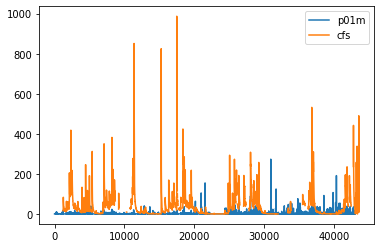

In [ ]:
import pandas as pd
import torch
from typing import Type

#01037380
df = pd.read_csv("joined/01037380KRKD_flow.csv")
df[['p01m', 'cfs']].plot.line()

In [ ]:
def interpolate_missing_values(df:pd.DataFrame)->pd.DataFrame:
  """
  Function to fill missing values with nearest
  value. Should be run only after splitting on the NaN
  chunks.
  """
  df['cfs1'] = df['cfs'].interpolate(method='nearest').ffill().bfill()
  df['precip'] = df['p01m'].interpolate(method='nearest').ffill().bfill()
  df['temp'] = df['tmpf'].interpolate(method='nearest').ffill().bfill()
  return df

df = interpolate_missing_values(df)
index = df[df['hour_updated'].astype('datetime64[ns]')==datetime(2018,6,1)].index[0]
index = index -72
data1 = df.iloc[index:index+336+72][['cfs1', 'precip', 'temp']]
s = StandardScaler()
#data.head()
new_df = s.fit_transform(df[['cfs1', 'precip', 'temp']])
data = new_df[index:index+336+72]
s.inverse_transform(new_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

array([[ 6.08000000e+00, -5.55111512e-17,  5.06615385e+01],
       [ 6.08000000e+00, -5.55111512e-17,  5.15535714e+01],
       [ 6.08000000e+00, -5.55111512e-17,  5.15000000e+01],
       ...,
       [ 1.80000000e+00, -5.55111512e-17,  5.44000000e+01],
       [ 1.73000000e+00, -5.55111512e-17,  5.37807692e+01],
       [ 1.73000000e+00, -5.55111512e-17,  5.34038462e+01]])

In [ ]:
data1[:72]

,cfs1,precip,temp
37823,6.27,0.0,50.450000
37824,6.08,0.0,50.042308
37825,6.08,0.0,50.661538
37826,6.08,0.0,51.553571
37827,6.08,0.0,51.500000
...,...,...,...
37890,3.79,0.0,70.670833
37891,3.79,0.0,70.242308
37892,3.79,0.0,67.796154
37893,3.79,0.0,66.319231


In [ ]:
data[:72]

array([[-0.52718686, -0.12896757,  0.26049052],
       [-0.53100262, -0.12896757,  0.23751313],
       [-0.53100262, -0.12896757,  0.27241275],
       [-0.53100262, -0.12896757,  0.3226874 ],
       [-0.53100262, -0.12896757,  0.31966814],
       [-0.53100262, -0.12896757,  0.31725272],
       [-0.53100262, -0.12896757,  0.32624343],
       [-0.53100262, -0.12896757,  0.35367178],
       [-0.53100262, -0.12896757,  0.41101771],
       [-0.53100262, -0.12896757,  0.42833656],
       [-0.53100262, -0.12896757,  0.42393346],
       [-0.53100262, -0.12896757,  0.4797295 ],
       [-0.53100262, -0.12896757,  0.67379451],
       [-0.53100262, -0.12896757,  1.01406581],
       [-0.53100262, -0.12896757,  1.36443487],
       [-0.53100262, -0.12896757,  1.60423428],
       [-0.53100262, -0.12896757,  1.73494528],
       [-0.53100262, -0.12896757,  1.82620453],
       [-0.53481837, -0.12896757,  1.92353329],
       [-0.53481837, -0.12896757,  1.81460746],
       [-0.53481837, -0.12896757,  1.692

In [ ]:
def simple_decode(model: Type[torch.nn.Module], src: torch.Tensor, max_seq_len: int, real_target: torch.Tensor, 
                        start_symbol=None, output_len=1, device='cpu', unsqueeze_dim=1, use_real_target:bool=True) -> torch.Tensor:
    """
    :model a PyTorch model to be used for decoding
    :src the source tensor
    :the max length sequence to return
    :real_target the actual target values we want to forecast (don't worry they are masked) 
    :start_symbol used to match the function signature of greedy_decode not ever used here though. 
    :output_len potentially used to forecast multiple steps at once. Not implemented yet though.
    :device used to to match function signature
    :returns a torch.Tensor of dimension (B, max_seq_len, M)
    """
    real_target = real_target.float()
    real_target2 = real_target.clone()
    ys = src[:, -1, :].unsqueeze(unsqueeze_dim)
    for i in range(0, max_seq_len):
        with torch.no_grad():
            print(src.shape)
            out = model(src)
            real_target2[:, i, 0] = out[:, 0]
            src = torch.cat((src[:, 1:, :], real_target2[:, i, :].unsqueeze(1)), 1)
            ys = torch.cat((ys, real_target2[:, i, :].unsqueeze(1)), 1)
    return ys[:, 1:, :]

In [ ]:

src = torch.from_numpy(data)[:72, :]
trg = torch.from_numpy(data)[72:, :]

In [ ]:
src = src.unsqueeze(0)
trg = trg.unsqueeze(0)

In [ ]:
print(trg.shape)
model.model.eval()
res = simple_decode(model.model, src.to(model.device).float(), 20, trg.to(model.device).float())

torch.Size([1, 336, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])


In [ ]:
s.inverse_transform(res.cpu())

array([[[-6.72684240e+00, -1.05533156e-08,  6.08615379e+01],
        [-6.15694189e+00, -1.05533156e-08,  5.88624992e+01],
        [-5.78274298e+00, -1.05533156e-08,  5.85346146e+01],
        [-5.29566336e+00, -1.05533156e-08,  5.90000000e+01],
        [-4.77489996e+00, -1.05533156e-08,  5.90000000e+01],
        [-4.35034704e+00, -1.05533156e-08,  5.90000000e+01],
        [-3.87310934e+00, -1.05533156e-08,  5.90769234e+01],
        [-2.97014380e+00, -1.05533156e-08,  6.00000000e+01],
        [-1.88213110e+00, -1.05533156e-08,  6.00000000e+01],
        [-1.28987646e+00, -1.05533156e-08,  6.01538467e+01],
        [-8.80879819e-01, -1.05533156e-08,  6.10833359e+01],
        [ 1.20035678e-01, -1.05533156e-08,  6.21923103e+01],
        [-1.16441220e-01, -1.05533156e-08,  6.37500000e+01],
        [-2.33011770e+00, -1.05533156e-08,  6.64833298e+01],
        [-3.68860769e+00, -1.05533156e-08,  7.02083359e+01],
        [-5.37735128e+00, -1.05533156e-08,  7.12615433e+01],
        [-5.39505911e+00

In [ ]:
data1[72:]
infer_params = {
          "datetime_start":"2018-06-01", 
          "hours_to_forecast":336,
          "decoder_params":{
              "decoder_function": "simple_decode", "unsqueeze_dim": 1},
          "test_csv_path":"joined/01037380KRKD_flow.csv",
          "dataset_params":{
              "file_path":"joined/01037380KRKD_flow.csv", 
              "forecast_history": 72, 
              "forecast_length":1, 
              "relevant_cols":["cfs1", "precip", "temp"], 
              "target_col":["cfs1"],
              "interpolate_param": True,
              "scaling": StandardScaler()
          }
          
        }

In [ ]:
from flood_forecast.evaluator import evaluate_model
num, df = evaluate_model(model, "PyTorch", ["cfs1"], ['MSE'], infer_params, {})

interpolate should be below
now filling missing values
Now loading and scaling joined/01037380KRKD_flow.csv
CSV Path below
joined/01037380KRKD_flow.csv
torch.Size([1, 72, 3])
Add debugging crap below
torch.Size([336])
test_data scale
Un-transforming data
Current historical dataframe
       Unnamed: 0  Unnamed: 0_x  ... original_index      preds
37825       37830       37827.0  ...          37825   0.000000
37826       37831       37828.0  ...          37826   0.000000
37827       37832       37829.0  ...          37827   0.000000
37828       37833       37830.0  ...          37828   0.000000
37829       37834       37831.0  ...          37829   0.000000
...           ...           ...  ...            ...        ...
38228       38233       38230.0  ...          38228  54.164497
38229       38234       38231.0  ...          38229  50.815941
38230       38235       38232.0  ...          38230  50.703098
38231       38236       38233.0  ...          38231  48.404823
38232       38237      

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/content/github_a

In [ ]:
df['preds'][72:]

37897    21.267900
37898    18.605011
37899    17.569427
37900    12.864519
37901     8.554314
           ...    
38228    54.164497
38229    50.815941
38230    50.703098
38231    48.404823
38232    48.821415
Name: preds, Length: 336, dtype: float64

In [ ]:
from flood_forecast.evaluator import infer_on_torch_model

In [ ]:
df2, end_tensor, forecast_history, junk, test_data  = infer_on_torch_model(model, **infer_params)

interpolate should be below
now filling missing values
Now loading and scaling joined/01037380KRKD_flow.csv
CSV Path below
joined/01037380KRKD_flow.csv
torch.Size([1, 72, 3])
Add debugging crap below
torch.Size([336])


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/py

In [ ]:
end_tensor

tensor([-0.2260, -0.2795, -0.3003, -0.3948, -0.4813, -0.5080, -0.5561, -0.5617,
        -0.5179, -0.4763, -0.4301, -0.4502, -0.4831, -0.5489, -0.6654, -0.6777,
        -0.7080, -0.6561, -0.6478, -0.6351, -0.6290, -0.5745, -0.5372, -0.5375,
        -0.6248, -0.5908, -0.5907, -0.5904, -0.5676, -0.5617, -0.5374, -0.5534,
        -0.5514, -0.5869, -0.6321, -0.6196, -0.5867, -0.5808, -0.5545, -0.5506,
        -0.5411, -0.5597, -0.5898, -0.6583, -0.6864, -0.6380, -0.5571, -0.4599,
        -0.4206, -0.4807, -0.5087, -0.6202, -0.6502, -0.7051, -0.7455, -0.6862,
        -0.6259, -0.6033, -0.6013, -0.5895, -0.5153, -0.4898, -0.5168, -0.4816,
        -0.4225, -0.3385, -0.2632, -0.1911, -0.1000, -0.0780, -0.1054, -0.0180,
         0.0252,  0.0083, -0.0456, -0.0593,  0.0522,  0.1454,  0.2496,  0.3036,
         0.3497,  0.3854,  0.3588,  0.3428,  0.3612,  0.3895,  0.4289,  0.4600,
         0.5350,  0.5873,  0.5398,  0.5134,  0.5021,  0.4792,  0.4639,  0.4930,
         0.5217,  0.5641,  0.6260,  0.64

In [ ]:
test_data.get_from_start_date("2018-6-01")

In [ ]:
history, df, forecast_start_idx = test_data.get_from_start_date("2018-6-01")

In [ ]:
test_data.original_df[forecast_start_idx-72:forecast_start_idx ]

,Unnamed: 0,Unnamed: 0_x,hour_updated,p01m,valid,tmpf,Unnamed: 0_y,agency_cd,site_no,datetime,tz_cd,65572_00060,65572_00060_cd,cfs,cfs1,precip,temp,original_index
37825,37830,37827.0,2018-05-29 02:00:00+00:00,0.0,2018-05-29 01:05,50.661538,115973.0,USGS,1037380.0,2018-05-29 02:00:00,EDT,6.08,A,6.08,6.08,0.0,50.661538,37825
37826,37831,37828.0,2018-05-29 03:00:00+00:00,0.0,2018-05-29 02:05,51.553571,115977.0,USGS,1037380.0,2018-05-29 03:00:00,EDT,6.08,A,6.08,6.08,0.0,51.553571,37826
37827,37832,37829.0,2018-05-29 04:00:00+00:00,0.0,2018-05-29 03:05,51.500000,115981.0,USGS,1037380.0,2018-05-29 04:00:00,EDT,6.08,A,6.08,6.08,0.0,51.500000,37827
37828,37833,37830.0,2018-05-29 05:00:00+00:00,0.0,2018-05-29 04:05,51.457143,115985.0,USGS,1037380.0,2018-05-29 05:00:00,EDT,6.08,A,6.08,6.08,0.0,51.457143,37828
37829,37834,37831.0,2018-05-29 06:00:00+00:00,0.0,2018-05-29 05:05,51.616667,115989.0,USGS,1037380.0,2018-05-29 06:00:00,EDT,6.08,A,6.08,6.08,0.0,51.616667,37829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37892,37897,37894.0,2018-05-31 21:00:00+00:00,0.0,2018-05-31 20:05,67.796154,116241.0,USGS,1037380.0,2018-05-31 21:00:00,EDT,3.79,A,3.79,3.79,0.0,67.796154,37892
37893,37898,37895.0,2018-05-31 22:00:00+00:00,0.0,2018-05-31 21:05,66.319231,116245.0,USGS,1037380.0,2018-05-31 22:00:00,EDT,3.79,A,3.79,3.79,0.0,66.319231,37893
37894,37899,37896.0,2018-05-31 23:00:00+00:00,0.0,2018-05-31 22:05,63.720833,116249.0,USGS,1037380.0,2018-05-31 23:00:00,EDT,3.79,A,3.79,3.79,0.0,63.720833,37894
37895,37900,37897.0,2018-06-01 00:00:00+00:00,0.0,2018-05-31 23:05,60.861538,116253.0,USGS,1037380.0,2018-06-01 00:00:00,EDT,3.79,A,3.79,3.79,0.0,60.861538,37895


In [ ]:
test_data.df[forecast_start_idx-72:forecast_start_idx ]

,cfs1,precip,temp
23991,-0.652105,-0.128971,0.601565
23993,-0.652105,-0.128971,0.306909
23995,-0.652306,-0.128971,0.066909
23997,-0.652306,-0.128971,0.015213
23999,-0.652506,-0.128971,-0.133594
...,...,...,...
24125,-0.652908,-0.128971,0.341575
24127,-0.652908,-0.128971,0.480448
24129,-0.652908,-0.128971,0.605370
24131,-0.652908,-0.128971,0.723317


In [ ]:
test_data.inverse_scale(history_dim.cpu())

tensor([[[ 4.9999e-02,  2.6099e+01,  6.2476e+01],
         [ 4.9999e-02,  2.6099e+01,  4.7804e+01],
         [ 4.0001e-02,  2.6099e+01,  3.5853e+01],
         [ 4.0001e-02,  2.6099e+01,  3.3279e+01],
         [ 3.0003e-02,  2.6099e+01,  2.5869e+01],
         [ 3.0003e-02,  2.6099e+01,  1.4093e+01],
         [ 3.0003e-02,  2.6099e+01,  8.7970e+00],
         [ 3.0003e-02,  2.6099e+01,  8.5444e+00],
         [ 3.0003e-02,  2.6099e+01,  3.1974e+01],
         [ 2.0001e-02,  2.6099e+01,  5.3546e+01],
         [ 2.0001e-02,  2.6099e+01,  6.3928e+01],
         [ 2.0001e-02,  2.6099e+01,  6.3928e+01],
         [ 2.0001e-02,  2.6099e+01,  6.1908e+01],
         [ 2.0001e-02,  2.6099e+01,  4.5059e+01],
         [ 2.0001e-02,  2.6099e+01,  3.0837e+01],
         [ 2.0001e-02,  2.6099e+01,  1.4851e+01],
         [ 2.0001e-02,  2.6099e+01,  1.3290e+01],
         [ 2.0001e-02,  2.6099e+01,  8.9724e+00],
         [ 2.0001e-02,  2.6099e+01,  8.5128e+00],
         [ 2.0001e-02,  2.6099e+01,  1.3439e+01],


In [ ]:
print(forecast_start_idx)

37895


In [ ]:
real_target_tensor = torch.from_numpy(test_data.df[forecast_start_idx:].to_numpy()).to(model.device).unsqueeze(0).to(model.device)

In [ ]:
real_target_tensor

tensor([[[-0.6529, -0.1290,  0.6815],
         [-0.6529, -0.1290,  0.6529],
         [-0.6529, -0.1290,  0.7423],
         ...,
         [-0.0265,  2.6377, -0.3423],
         [ 0.1863,  0.5511, -0.1832],
         [ 0.1863, -0.1290, -0.0653]]], device='cuda:0', dtype=torch.float64)

In [ ]:
test_data.inverse_scale(history_dim.cpu())

tensor([[[ 4.9999e-02,  2.6099e+01,  6.2476e+01],
         [ 4.9999e-02,  2.6099e+01,  4.7804e+01],
         [ 4.0001e-02,  2.6099e+01,  3.5853e+01],
         [ 4.0001e-02,  2.6099e+01,  3.3279e+01],
         [ 3.0003e-02,  2.6099e+01,  2.5869e+01],
         [ 3.0003e-02,  2.6099e+01,  1.4093e+01],
         [ 3.0003e-02,  2.6099e+01,  8.7970e+00],
         [ 3.0003e-02,  2.6099e+01,  8.5444e+00],
         [ 3.0003e-02,  2.6099e+01,  3.1974e+01],
         [ 2.0001e-02,  2.6099e+01,  5.3546e+01],
         [ 2.0001e-02,  2.6099e+01,  6.3928e+01],
         [ 2.0001e-02,  2.6099e+01,  6.3928e+01],
         [ 2.0001e-02,  2.6099e+01,  6.1908e+01],
         [ 2.0001e-02,  2.6099e+01,  4.5059e+01],
         [ 2.0001e-02,  2.6099e+01,  3.0837e+01],
         [ 2.0001e-02,  2.6099e+01,  1.4851e+01],
         [ 2.0001e-02,  2.6099e+01,  1.3290e+01],
         [ 2.0001e-02,  2.6099e+01,  8.9724e+00],
         [ 2.0001e-02,  2.6099e+01,  8.5128e+00],
         [ 2.0001e-02,  2.6099e+01,  1.3439e+01],


In [ ]:
test_data.df[37895:73+37895]

,cfs1,precip,temp
24135,-0.652908,-0.128971,0.681464
24137,-0.652908,-0.128971,0.652929
24139,-0.652908,-0.128971,0.742340
24141,-0.652908,-0.128971,0.796452
24143,-0.652908,-0.128971,0.681464
...,...,...,...
25286,-0.118914,-0.128971,-1.328614
25287,-0.118914,-0.128971,-1.409919
25288,-0.118914,-0.128971,-1.493529
25289,-0.118914,-0.128971,-1.550717


In [ ]:
real_target_tensor = torch.from_numpy(test_data.df[forecast_start_idx-1:].to_numpy()).to(model.device).unsqueeze(0).to(model.device)
real_target_tensor

tensor([[[-0.6529, -0.1290,  0.8032],
         [-0.6529, -0.1290,  0.6815],
         [-0.6529, -0.1290,  0.6529],
         ...,
         [-0.0265,  2.6377, -0.3423],
         [ 0.1863,  0.5511, -0.1832],
         [ 0.1863, -0.1290, -0.0653]]], device='cuda:0', dtype=torch.float64)

In [ ]:
#-0.6521, -0.1290,  0.6016
#-0.6529, -0.1290,  0.8032
history_dim

tensor([[[-0.6521, -0.1290,  0.6016],
         [-0.6521, -0.1290,  0.3069],
         [-0.6523, -0.1290,  0.0669],
         [-0.6523, -0.1290,  0.0152],
         [-0.6525, -0.1290, -0.1336],
         [-0.6525, -0.1290, -0.3701],
         [-0.6525, -0.1290, -0.4764],
         [-0.6525, -0.1290, -0.4815],
         [-0.6525, -0.1290, -0.0110],
         [-0.6527, -0.1290,  0.4222],
         [-0.6527, -0.1290,  0.6307],
         [-0.6527, -0.1290,  0.6307],
         [-0.6527, -0.1290,  0.5902],
         [-0.6527, -0.1290,  0.2518],
         [-0.6527, -0.1290, -0.0338],
         [-0.6527, -0.1290, -0.3549],
         [-0.6527, -0.1290, -0.3862],
         [-0.6527, -0.1290, -0.4729],
         [-0.6527, -0.1290, -0.4822],
         [-0.6527, -0.1290, -0.3832],
         [-0.6527, -0.1290,  0.1680],
         [-0.6527, -0.1290,  0.7484],
         [-0.6527, -0.1290,  0.7667],
         [-0.6527, -0.1290,  0.7423],
         [-0.6527, -0.1290,  0.6583],
         [-0.6527, -0.1290,  0.3963],
         [-0

In [ ]:
history_dim

tensor([[[-0.6521, -0.1290,  0.6016],
         [-0.6521, -0.1290,  0.3069],
         [-0.6523, -0.1290,  0.0669],
         [-0.6523, -0.1290,  0.0152],
         [-0.6525, -0.1290, -0.1336],
         [-0.6525, -0.1290, -0.3701],
         [-0.6525, -0.1290, -0.4764],
         [-0.6525, -0.1290, -0.4815],
         [-0.6525, -0.1290, -0.0110],
         [-0.6527, -0.1290,  0.4222],
         [-0.6527, -0.1290,  0.6307],
         [-0.6527, -0.1290,  0.6307],
         [-0.6527, -0.1290,  0.5902],
         [-0.6527, -0.1290,  0.2518],
         [-0.6527, -0.1290, -0.0338],
         [-0.6527, -0.1290, -0.3549],
         [-0.6527, -0.1290, -0.3862],
         [-0.6527, -0.1290, -0.4729],
         [-0.6527, -0.1290, -0.4822],
         [-0.6527, -0.1290, -0.3832],
         [-0.6527, -0.1290,  0.1680],
         [-0.6527, -0.1290,  0.7484],
         [-0.6527, -0.1290,  0.7667],
         [-0.6527, -0.1290,  0.7423],
         [-0.6527, -0.1290,  0.6583],
         [-0.6527, -0.1290,  0.3963],
         [-0

In [ ]:
res = simple_decode(model.model, history_dim, 20, real_target_tensor)

torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])
torch.Size([1, 72, 3])


In [ ]:
res

tensor([[[-0.2260, -0.1290,  0.8032],
         [-0.2824, -0.1290,  0.6815],
         [-0.3060, -0.1290,  0.6529],
         [-0.3918, -0.1290,  0.7423],
         [-0.4763, -0.1290,  0.7965],
         [-0.5157, -0.1290,  0.6815],
         [-0.5636, -0.1290,  0.7056],
         [-0.5622, -0.1290,  0.5699],
         [-0.5256, -0.1290,  0.4769],
         [-0.4815, -0.1290,  0.6561],
         [-0.4130, -0.1290,  1.1604],
         [-0.4307, -0.1290,  1.3612],
         [-0.4797, -0.1290,  1.4610],
         [-0.5617, -0.1290,  1.1418],
         [-0.6740, -0.1290,  0.6626],
         [-0.6796, -0.1290,  0.5220],
         [-0.6892, -0.1290,  0.4564],
         [-0.6576, -0.1290,  0.4075],
         [-0.6359, -0.1290,  0.3627],
         [-0.6462, -0.1290,  0.3276]]], device='cuda:0')

In [ ]:
test_data.targ_scaler.inverse_transform(res.cpu())

array([[[ 21.2679    ,  26.09925   ,  72.51709   ],
        [ 18.459932  ,  26.09925   ,  66.45453   ],
        [ 17.285555  ,  26.09925   ,  65.03361   ],
        [ 13.011675  ,  26.09925   ,  69.48581   ],
        [  8.8042755 ,  26.09925   ,  72.18028   ],
        [  6.8426704 ,  26.09925   ,  66.45453   ],
        [  4.455055  ,  26.09925   ,  67.65441   ],
        [  4.5269566 ,  26.09925   ,  60.89717   ],
        [  6.3496914 ,  26.09925   ,  56.266045  ],
        [  8.544413  ,  26.09925   ,  65.19149   ],
        [ 11.95619   ,  26.09925   ,  90.30062   ],
        [ 11.075024  ,  26.09925   , 100.303856  ],
        [  8.6346245 ,  26.09925   , 105.27179   ],
        [  4.5513954 ,  26.09925   ,  89.3786    ],
        [ -1.0422896 ,  26.09925   ,  65.51627   ],
        [ -1.316677  ,  26.09925   ,  58.51545   ],
        [ -1.7949599 ,  26.09925   ,  55.24509   ],
        [ -0.22391884,  26.09925   ,  52.81375   ],
        [  0.8572274 ,  26.09925   ,  50.58239   ],
        [  0

In [ ]:
!cat /var/log/colab-jupyter.log

{"name":"app","hostname":"22f78161e9fa","pid":8,"type":"jupyter","level":40,"msg":"/usr/local/lib/python2.7/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.","time":"2020-04-24T22:28:33.801Z","v":0}
{"name":"app","hostname":"22f78161e9fa","pid":8,"type":"jupyter","level":40,"msg":"  warn(\"IPython.utils.traitlets has moved to a top-level traitlets package.\")","time":"2020-04-24T22:28:33.803Z","v":0}
{"name":"app","hostname":"22f78161e9fa","pid":8,"type":"jupyter","level":30,"msg":"Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret","time":"2020-04-24T22:28:35.102Z","v":0}
{"name":"app","hostname":"22f78161e9fa","pid":8,"type":"jupyter","level":30,"msg":"google.colab serverextension initialized.","time":"2020-04-24T22:28:35.233Z","v":0}
{"name":"app","hostname":"22f78161e9fa","pid":8,"type":"jupyter","level":30,"msg":"Serving notebooks from local directory: /","ti

In [ ]:
import json

with open("/var/log/colab-jupyter.log", "r") as fo:
  for line in fo:
    print(json.loads(line)['msg'])

/usr/local/lib/python2.7/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret
google.colab serverextension initialized.
Serving notebooks from local directory: /
0 active kernels
The Jupyter Notebook is running at:
http://172.28.0.2:9000/
Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
Kernel started: e6e5f597-8f42-438f-9ad1-78fb28b06a10
/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
Adapting to protocol v5.1 for kernel e6e5f597-8f42-438f-9ad1-78fb28b06a10
KernelRestarter: restarting kernel (1/5), keep random ports
/usr/lo

In [ ]:
import torch
from torchsummary import summary
class LSTMForecast(torch.nn.Module):
    """
    A very simple baseline LSTM model that returns
    an output sequence given a multi-dimensional input seq. Inspired by the StackOverflow link below.
    https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
    """
    def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states:int=20, num_layers=2, bias=True, batch_size=100):
        super().__init__()
        self.forecast_history = seq_length
        self.n_time_series = n_time_series
        self.hidden_dim = hidden_states
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
        self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)
        self.init_hidden(batch_size)
    
    def init_hidden(self, batch_size)->None:
        # This is what we'll initialise our hidden state
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim), torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size()[0]
        self.init_hidden(batch_size)
        out_x, self.hidden = self.lstm(x, self.hidden)
        x = self.final_layer(out_x.contiguous().view(batch_size, -1))
        return x

In [ ]:
model = LSTMForecast(1, 1, batch_size=1).to('cuda')

In [ ]:
a = torch.rand(1, 1, 1).to('cuda')
model(a)

In [ ]:
summary(model, (1,1))

NameError: ignored

In [ ]:
!git pull origin/error_bug

fatal: 'origin/error_bug' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


fatal: 'master/bug_error' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!git clone https://github.com/AIStream-Peelout/flow-forecast.git -b error_bug